# Definitions

In [93]:
# General definitions
%run '../definitions.ipynb'
%run '../treemakers/treemakers.py'
%run '../Analysis_class.ipynb'

### Data location

In [94]:
processed_data_path = '/data/xenon/xams/run8/processed_v2_medium/'
minitree_path = '/data/xenon/xams/run8/minitrees/'

In [95]:
# Long runs limited to 6 hours because of S2 decrease.
run_names_ambe_1 = get_run_list(processed_data_path, '170321_155957', '170321_214847') # Last file: 170322_081037
run_names_ambe_2 = get_run_list(processed_data_path, '170322_154130', '170322_213020') # Last file: 170322_233141
run_names_bg     = get_run_list(processed_data_path, '170323_175029', '170323_232220') # Last file: 170324_072500
run_names_cs     = get_run_list(processed_data_path, '170323_144804', '170323_151843') # 
run_names_na_0   = get_run_list(processed_data_path, '170323_121631', '170323_134830') # DAQ crashes in here
run_names_na_1   = get_run_list(processed_data_path, '170323_140425', '170323_142831') # 

# UNPROCESSED FILES AS OF AUGUST 30, 2017
# 170324_115549_pre_crash
# run_names_ambe_0 = get_run_list(processed_data_path, '170320_160942', '170320_160942') # Just one file, half hour

run_names_ambe_low = get_run_list(processed_data_path, '170324_093626', '170324_124119')
run_names_cs_low   = get_run_list(processed_data_path, '170324_130241', '170324_144835')

Run list contains 24 files
Run list contains 24 files
Run list contains 12 files
Run list contains 5 files
Run list contains 6 files
Run list contains 4 files
Run list contains 12 files
Run list contains 7 files


### Loading data

In [96]:
def read_and_cut(run_names, processed_data_path, minitree_path, treemakers = None, config = 'highfield', **kwargs):
    if 'pickle_file' in kwargs.keys():
        if not kwargs.get('force_reload', False):
            try:
                with open(kwargs['pickle_file'], 'rb') as f:
                    x = pickle.load(f)
                print('Read %d events from file %s' % (len(x.d), kwargs['pickle_file']))
                return x
            except:
                print('Pickle not found, now starting loading...')
    
    if config == 'highfield':
        v_d = 1.73
    elif config == 'lowfield':
        v_d = 1.404
    else:
        raise ValueError('Error in config, got config = %s' % config)
    
    x = XAMSAnalysis(run_names, processed_data_path, minitree_path)
    x.load(treemakers=  treemakers)
    x.corr_z(1.5, v_d)
    x.corr_s1_ly_poly(ly_filename='../light_yield/data/cs137_ly_p2_sel2.pickle')
    x.corr_s2_electron_lifetime(pickle_file='../light_yield/data/cs137_electron_lifetime_sel2.pickle', verbose=True)
    x.cut_interaction_exists()
    x.cut_time_since_previous()
    x.cut_fiducial_volume()
    # x.cut_s2_range_50p_area(pickle_file='../light_yield/data/cs137_s2_width.pickle')
    x.cut_thresholds(s1_threshold=0, s2_threshold=100.)
    x.cut_largest_other_s1()
    x.cut_largest_other_s2()
    x.cut_low_energy(cs1_max = 400, cs2_max = 1e6)
    print('Events left: %.1f k' % (len(x.d)/1000))
    
    if 'pickle_file' in kwargs.keys():
        with open(kwargs['pickle_file'], 'wb') as f:
            pickle.dump(x, f)
        
    return x

In [97]:
treemakers = ['Basics', 'Fundamentals', S1TimeProperties]

### Band fit functions

In [98]:
def slice_cs1cs2(df, cs1_limits, verbose = False):
    '''
    Make a slice in cs1 and return cs2
    '''
    sel = np.array((df['cs1'] >= cs1_limits[0]) & (df['cs1'] < cs1_limits[1]))
    if verbose: print('Selected %d of %d events (%.2f %%)' % (sum(sel), len(df), 100 * sum(sel) / len(df), ))
    return df['cs2'].values[sel]

In [99]:
def find_max_in_slice(x, hist_range, hist_bins, plot=False):
    '''
    Make a histogram and find the maximum value. Used as an input into fitting.
    '''
    counts, bin_edges = np.histogram(x, range=hist_range, bins=hist_bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    max_pos = bin_centers[np.argmax(counts)]
    if plot: 
        plt.plot(bin_centers, counts, ls='steps')
        plt.axvline(max_pos)
    return max_pos

In [100]:
def fit_slice(x, mu_guess, sigma_guess, sigma_range, iterations = 20, **kwargs):
    '''
    Fit one slice in cs1 (use output from `slice_cs1cs2`). Limits for mu and sigma may be passed
    as kwargs, default is set to (100, 25e3) and (200, 10e3), respectively. Set using `limit_x0` and `limit_x1`.
    '''
    limit_x0 = kwargs.get('limit_x0', (100, 25e3))
    limit_x1 = kwargs.get('limit_x1', (200, 10e3))
    
    mu_guesses = [mu_guess]
    for i in range(iterations):
        range_guess = (mu_guess - sigma_range * sigma_guess, mu_guess + sigma_range * sigma_guess)
        popt, perr, m = fit_unbinned(x, gaus, (mu_guess, sigma_guess), fit_range=range_guess, 
                                        print_level = 0, p0_error = [1,1], limit_x0 = limit_x0, 
                                     limit_x1 = limit_x1)
        mu_guess, sigma_guess = 0.5 * (popt + np.array([mu_guess, sigma_guess]))
        mu_guesses.append(mu_guess)
    return np.concatenate([popt, perr])

In [101]:
def gaus(x, mu,sigma):
    return np.exp(- (x - mu)**2 / (2 * sigma **2))

def two_gaus(x, mu0, sigma0, mu1, sigma1, r):
    return gaus(x, mu0, sigma0) + r * gaus(x, mu1, sigma1)

In [102]:
def fit_band(df, start, stop, nbins, mode='progressive', sigma_range=1.5, **kwargs):
    '''
    Band fitting. Modes: 
      max_bin: use the maximum value of some histogram
      constant: use constant guess values for mu and sigma
      progressive: use a constant guess value for the first slice for mu and sigma, then work up using previous values.
    '''
    # Define the slices
    band_bin_edges = np.linspace(start, stop, nbins + 1)
    band_bins = 0.5 * (band_bin_edges[1:] + band_bin_edges[:-1])
    band = []
    
    # Loop over slice boundaries
    for low, high, mid in zip(band_bin_edges[:-1], band_bin_edges[1:], band_bins):
        # Slice in cS1
        cs2_slice = slice_cs1cs2(df, (low, high), False)
        
        # Get the guess values!
        if mode == 'max_bin':
            mu_guess = find_max_in_slice(cs2_slice, **kwargs)
            sigma_guess = 0.25 * mu_guess
        elif mode == 'constant':
            mu_guess = kwargs['mu_guess']
            sigma_guess = kwargs['sigma_guess']
        elif mode == 'progressive':
            if len(band) == 0:
                mu_guess = kwargs['mu_guess']
                sigma_guess = kwargs['sigma_guess']
            else:
                mu_guess = band[-1][1]
                sigma_guess = band[-1][2]
                
        # Given the slice and initial values, proceed to fit
        limit_x0 = kwargs.get('limit_x0', (100, 25e3))
        limit_x1 = kwargs.get('limit_x1', (200, 10e3))
        params = fit_slice(cs2_slice, mu_guess, sigma_guess, sigma_range, limit_x0 = limit_x0, limit_x1 = limit_x1)
        
        band.append(np.concatenate([[mid] ,  params]))
    return np.array(band)

#### Band filtering

In [103]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

#### Band processing

In [104]:
def process_band(band):
    mu_hat = savitzky_golay(band[:, 1], window_size=3, order=1)
    plus   = savitzky_golay(band[:, 1] + band[:, 2], window_size=3, order=1)
    minus  = savitzky_golay(band[:, 1] - band[:, 2], window_size=3, order=1)

    f_mu = scipy.interpolate.interp1d(band[:, 0], mu_hat, bounds_error=False, fill_value='extrapolate')
    f_plus = scipy.interpolate.interp1d(band[:, 0], plus, bounds_error=False, fill_value='extrapolate')
    f_minus = scipy.interpolate.interp1d(band[:, 0], minus, bounds_error=False, fill_value='extrapolate')
    
    return f_minus, f_mu, f_plus

In [105]:
def get_energy(cs1, band, pickle_file = '/home/erik/win/xams/analysis/light_yield/data/doke_sel2.pickle'):
    '''
    Get the energy of an event EXACTLY on the band, from CES.
    Is this a wrong way to go? Should we rather bin in CES?
    '''
    # mu for the band
    cs2 = band[1](cs1)
    with open(pickle_file, 'rb') as f:
        g1, g2 = pickle.load(f)
    energy_s1 = (cs1 / g1) * 13.7e-3
    energy_s2 = (cs2 / g2) * 13.7e-3
    print(energy_s1, energy_s2)
    return energy_s1 + energy_s2

In [106]:
def cut_band(x, band):
    ''' 
    Cut on events that should be in band. Requires band input: (low, middle, high) interpolating functions.
    '''
    xnew = deepcopy(x)
    xnew.d = cuts.selection(xnew.d, xnew.d['cs2'] < band[2](xnew.d['cs1']), 'Band upper limit')
    xnew.d = cuts.selection(xnew.d, xnew.d['cs2'] > band[0](xnew.d['cs1']), 'Band lower limit')
    return xnew

#### Plotting functions

In [107]:
def plot_raw_band(band, **kwargs):
    plt.plot(band[:, 0], band[:, 1], marker='.', markersize=10, color='red',**kwargs)
    plt.plot(band[:, 0], band[:, 1] - band[:, 2], marker='.', color='orange', **kwargs)
    plt.plot(band[:, 0], band[:, 1] + band[:, 2], marker='.', color='orange', **kwargs)

In [108]:
def plot_processed_band(band, cs1_range = (0, 400), num=400, **kwargs):
    x_plot = np.linspace(*cs1_range, num=num)
    for i in (0, 2):
        plt.plot(x_plot, band[i](x_plot), color='orange', **kwargs)
    plt.plot(x_plot, band[1](x_plot), color='red', **kwargs)
    return

In [109]:
def plot_dfs_diffs(fg, bg, **kwargs):
    cs1 = np.concatenate([fg.d['cs1'], bg.d['cs1']])
    cs2 = np.concatenate([fg.d['cs2'], bg.d['cs2']])
    scaling = fg.livetime / bg.livetime
    weights = np.concatenate([np.ones(len(fg.d)), np.ones(len(bg.d)) * (- scaling)])
    plt.hist2d(cs1, cs2, weights=weights, **kwargs)
    return

### S2 decrease correction

In [110]:
def correct_decrease(x, time_max, time_bins, 
                     cs1_max, cs1_bins, cs1_slice_to_exclude,
                     mu_guess, sigma_guess, sigma_range,
                     limit_x0,
                     filtered = False, 
                     plot=True, plot_all_bands = False, apply = False):
    '''
    Correct for S2 decrease over time.
    '''
    # Bin the time
    time_bands = []
    time_bin_edges = np.linspace(0, time_max, time_bins + 1)
    time_centers = 0.5 * (time_bin_edges[:-1] + time_bin_edges[1:])
    
    for time_start, time_stop in zip(time_bin_edges[:-1], time_bin_edges[1:]):
        time_range = (time_start, time_stop) 
        time_slice = x.d[(x.d['t'] >= time_range[0]) & (x.d['t'] < time_range[1])]
        # Fit the band in the current time slice
        _band = fit_band(time_slice, 0, cs1_max, cs1_bins, mode='progressive', 
                         mu_guess= mu_guess, sigma_guess= sigma_guess, limit_x0 = limit_x0,
                         sigma_range=1.5)
        if plot_all_bands:
            plot_raw_band(_band)
            plt.hist2d(time_slice['cs1'], time_slice['cs2'], range=((0, cs1_max), (0, 1.5*limit_x0[1])), 
                       bins=100, norm=LogNorm())
            plt.show()
        time_bands.append(_band)
    # This high-dimensional array contains the band for all time slices
    ob = np.array(time_bands)
    
    if plot:
        # Plot the change in band position over time
        for point_n in range(cs1_bins):
            plt.plot(time_centers * 1/3600, ob[:, :, 1][:, point_n] / ob[:, :, 1][0, point_n], 
                     marker='.', markersize= 10, label='Slice %d' % point_n, alpha=0.3)
        plt.legend(loc=(1,0))
        plt.xlabel('t (hours)')
        plt.ylabel('mu_cS2 / mu_cS2(t=0)')

        
        avg_scaling = np.average([ob[:, :, 1][:, point_n] / ob[:, :, 1][0, point_n] 
                                  for point_n in range(cs1_bins) if point_n not in cs1_slice_to_exclude], axis=0)
        fcorr = scipy.interpolate.interp1d(time_centers, 1/avg_scaling,
                                           kind = 'linear', fill_value='extrapolate', bounds_error=False)
        fplot = scipy.interpolate.interp1d(time_centers, avg_scaling,
                                           kind = 'linear', fill_value='extrapolate', bounds_error=False)
        
        avg_scaling_filtered = savitzky_golay(avg_scaling, window_size=3, order=0)
        fcorr_filtered = scipy.interpolate.interp1d(time_centers, 1/avg_scaling_filtered,
                                           kind = 'linear', fill_value='extrapolate', bounds_error=False)
        fplot_filtered = scipy.interpolate.interp1d(time_centers, avg_scaling_filtered,
                                           kind = 'linear', fill_value='extrapolate', bounds_error=False)
        # NOTE TO SELF interpolation of 1/x is NOT the same as 1/(interpolation of x)
        plt.plot(time_centers * 1/3600, avg_scaling,
                 marker='.', markersize= 10, label='avg')

        x_plot = np.linspace(0, 3600 * 6, 200)
        if filtered:
            plt.plot(x_plot / 3600, fplot_filtered(x_plot), color='red', ls='--')
        else:
            plt.plot(x_plot / 3600, fplot(x_plot), color='red', ls='--')
        plt.show()
        
    if apply:
        x.corr_s2_decrease(fcorr)
        
    return

# Highfield data

In [111]:
reload_all = False
ambe_1 = read_and_cut(run_names_ambe_1, processed_data_path, minitree_path, treemakers = treemakers, 
                      pickle_file = '/home/erik/win/data/xams_run8/ambe_1.pickle', force_reload = reload_all)
ambe_2 = read_and_cut(run_names_ambe_2, processed_data_path, minitree_path, treemakers = treemakers,
                      pickle_file = '/home/erik/win/data/xams_run8/ambe_2.pickle', force_reload = reload_all)
bg     = read_and_cut(run_names_bg, processed_data_path, minitree_path, treemakers = treemakers,
                     pickle_file = '/home/erik/win/data/xams_run8/bg.pickle', force_reload = reload_all)
cs     = read_and_cut(run_names_cs, processed_data_path, minitree_path, treemakers = treemakers,
                      pickle_file = '/home/erik/win/data/xams_run8/cs.pickle', force_reload = reload_all)
na_0   = read_and_cut(run_names_na_0, processed_data_path, minitree_path, treemakers = treemakers + [NaIProperties],
                      pickle_file = '/home/erik/win/data/xams_run8/na_0.pickle', force_reload = reload_all)
na_1   = read_and_cut(run_names_na_1, processed_data_path, minitree_path, treemakers = treemakers + [NaIProperties],
                      pickle_file = '/home/erik/win/data/xams_run8/na_1.pickle', force_reload = reload_all)

Read 121980 events from file /home/erik/win/data/xams_run8/ambe_1.pickle
Read 126530 events from file /home/erik/win/data/xams_run8/ambe_2.pickle
Read 85862 events from file /home/erik/win/data/xams_run8/bg.pickle
Read 16607 events from file /home/erik/win/data/xams_run8/cs.pickle
Read 10743 events from file /home/erik/win/data/xams_run8/na_0.pickle
Read 10923 events from file /home/erik/win/data/xams_run8/na_1.pickle


### Decrease correction

#### BG

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


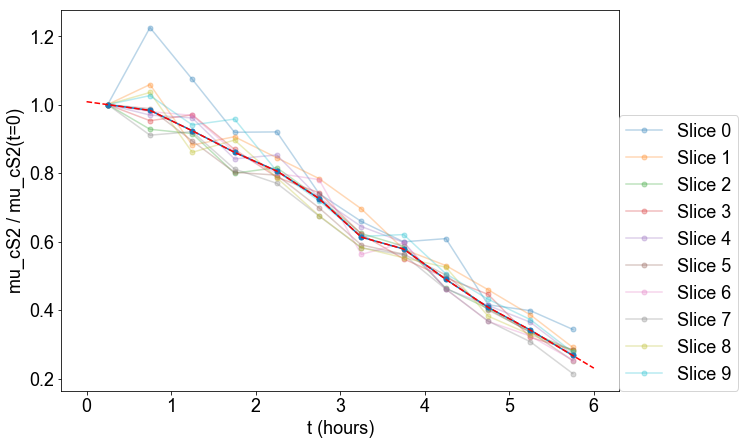

In [112]:
correct_decrease(bg, 3600 * 6, 12, 200, 10, [0], 2000, 800, 1.5, limit_x0 = (100, 25e3),
                 filtered=False,
                 plot=True, plot_all_bands=False, apply=True)

#### AmBe_1


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


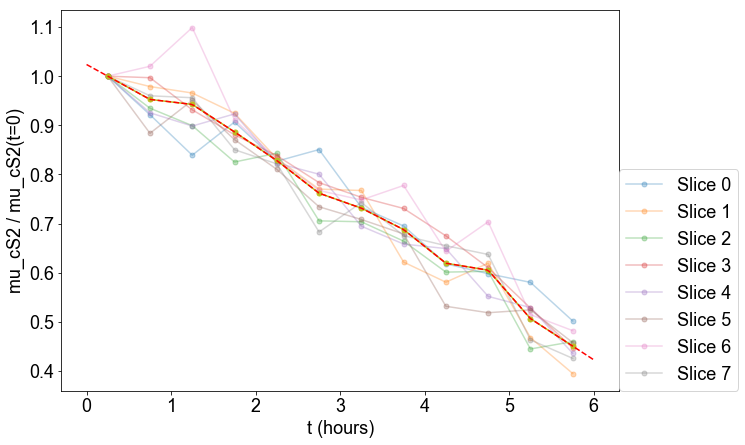

In [113]:
correct_decrease(ambe_1, 3600 * 6, 12, 80, 8, [], 500, 300, 1.5, limit_x0 = (100, 3e3),
                 filtered=False,
                 plot=True, plot_all_bands=False, apply=True)

#### AmBe_2

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


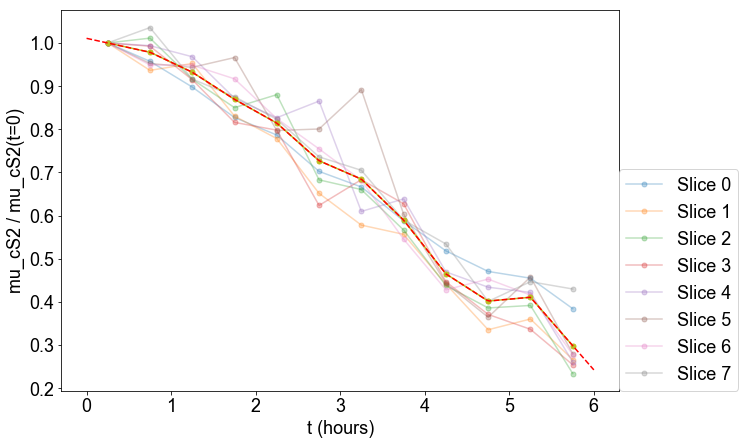

In [114]:
correct_decrease(ambe_2, 3600 * 6, 12, 80, 8, [], 500, 300, 1.5, limit_x0 = (100, 3e3),
                 filtered=False,
                 plot=True, plot_all_bands=False, apply=True)

### S2 width

#### Fit widths

In [118]:
df_list = [ambe_1, ambe_2, bg, cs, na_0, na_1]
labels = ['ambe_1', 'ambe_2', 'bg', 'cs', 'na_0', 'na_1']
# High width
for df, label in zip(df_list, labels):
    df.cut_s2_range_50p_area(mode='semi', dt_range = (5, 57), apply=True, verbose=True, plot = False)

# # Low width
# for df in df_list:
#     df.cut_s2_range_50p_area_low(-50, apply=False)

DEBUG:hax.cuts:s2_width_difference below 251.5 selection already performed on this data; cut skipped. Use force_repeat=True to repeat. Showing historical passthrough info.


Using diffusion constant 15.48 cm**2 / s
w0 found: 364.09 ns


DEBUG:hax.cuts:s2_width_difference below 251.5 selection already performed on this data; cut skipped. Use force_repeat=True to repeat. Showing historical passthrough info.


Using diffusion constant 15.48 cm**2 / s
w0 found: 354.31 ns
Using diffusion constant 15.48 cm**2 / s
w0 found: 418.64 ns


DEBUG:hax.cuts:s2_width_difference below 251.5 selection already performed on this data; cut skipped. Use force_repeat=True to repeat. Showing historical passthrough info.
DEBUG:hax.cuts:s2_width_difference below 251.5 selection already performed on this data; cut skipped. Use force_repeat=True to repeat. Showing historical passthrough info.


Using diffusion constant 15.48 cm**2 / s
w0 found: 435.09 ns
Using diffusion constant 15.48 cm**2 / s
w0 found: 449.30 ns


DEBUG:hax.cuts:s2_width_difference below 251.5 selection already performed on this data; cut skipped. Use force_repeat=True to repeat. Showing historical passthrough info.
DEBUG:hax.cuts:s2_width_difference below 251.5 selection already performed on this data; cut skipped. Use force_repeat=True to repeat. Showing historical passthrough info.


Using diffusion constant 15.48 cm**2 / s
w0 found: 447.98 ns


In [119]:
w0s = [364.99, 355.04, 419.13, 435.68, 449.92, 448.60]

#### Check SC data

What is the reason of the changing S2 width $w_0$? Well, that may be the liquid level! Let's check the SC file.

In [117]:
%run '../sc.ipynb'

sc = pd.concat(
    [
    read_xams_sc(fn = '/data/xenon/xams/run8/SC_data/%d-3-2017' % i, properties = ['Timestamp', 'Level'], verbose=False)
        for i in [21, 22, 23, 24]])
sc = sc[sc['Level'] > 0]

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


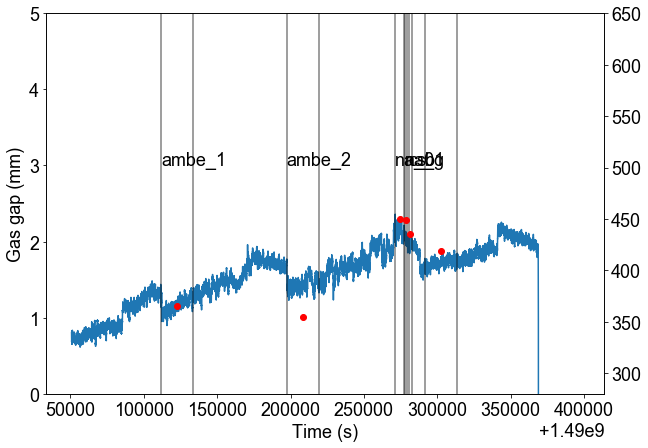

In [29]:
filtered_level = savitzky_golay(sc['Level'].values, window_size=121, order = 1)
# plt.plot(sc['unix_time'], sc['Level'])
plt.plot(sc['unix_time'], 5 - filtered_level)
for df, label in zip(df_list, labels):
    for t in (df.start_time, df.end_time):
        plt.axvline(t, label=label, color='black', alpha=0.5)
    plt.text(df.start_time, 3,  label)

plt.ylim(0, 5)
plt.xlim(ambe_1.start_time - 10000, bg.end_time + 10000)
plt.ylabel('Gas gap (mm)')
plt.xlabel('Time (s)')
plt.twinx()
#for df, label, w0 in zip(df_list, labels, w0s):
plt.scatter([0.5 * (df.start_time + df.end_time) for df in df_list], w0s, color='red')
plt.ylim(280, 650)
plt.show()

### S1 AFT posrec

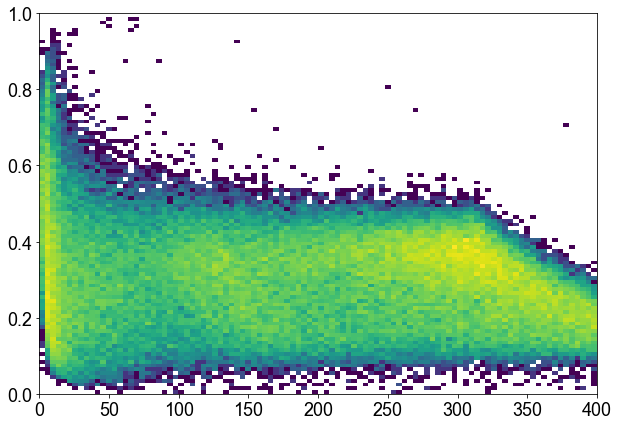

In [54]:
plt.hist2d(ambe_2.d['s1'], ambe_2.d['s1_area_fraction_top'], bins=100, norm=LogNorm(), range=((0,400), (0, 1)))
plt.show()

In [ ]:
def gaus_bg(x, mu, sigma, offset):
    return gaus(x, mu, sigma) + offset

[  1.19675780e-01   3.37741690e-02   6.01463224e-05]


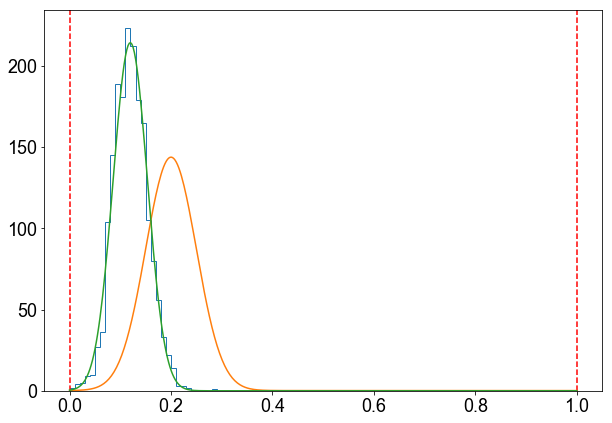

[  1.35687905e-01   3.70789038e-02   3.86832957e-10]


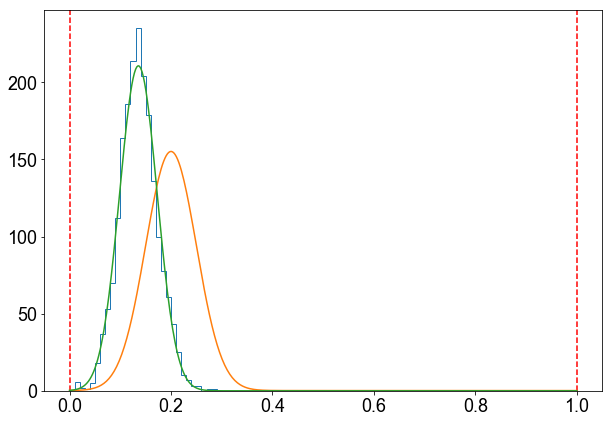

[  1.52283501e-01   4.00915724e-02   3.68115233e-08]


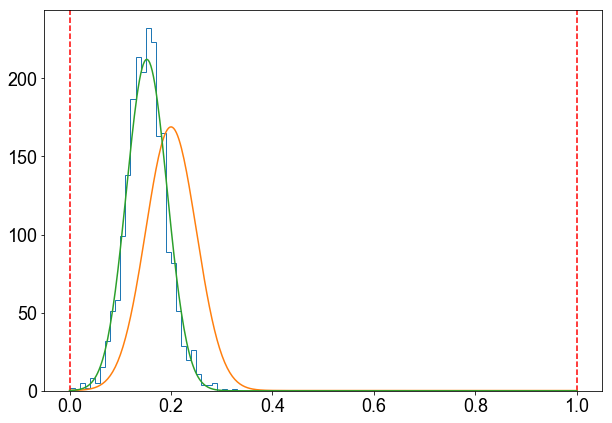

[  1.68200122e-01   3.96270181e-02   7.68019510e-07]


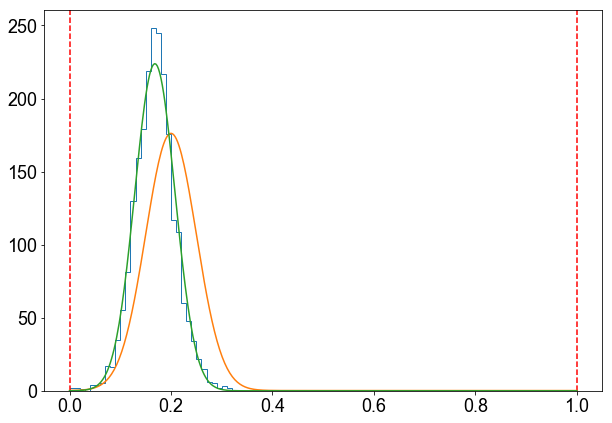

[  1.85172844e-01   4.17524951e-02   1.63140055e-04]


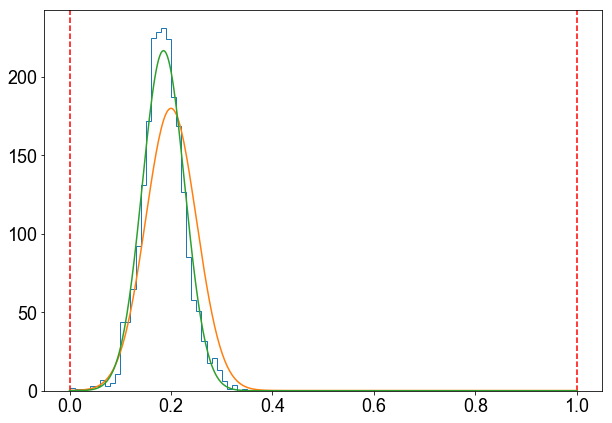

[  2.03604486e-01   4.17090616e-02   9.37034450e-05]


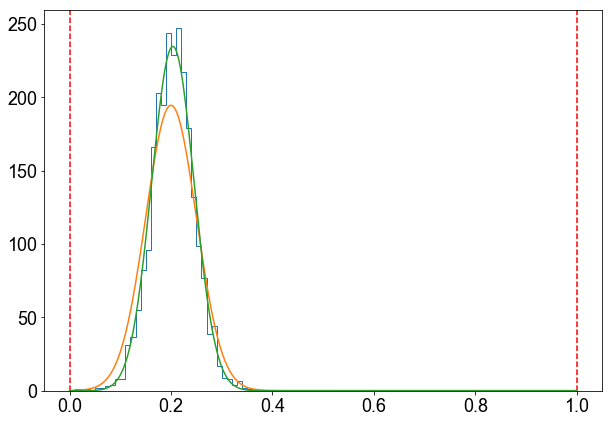

[ 0.22169071  0.04370166  0.00068317]


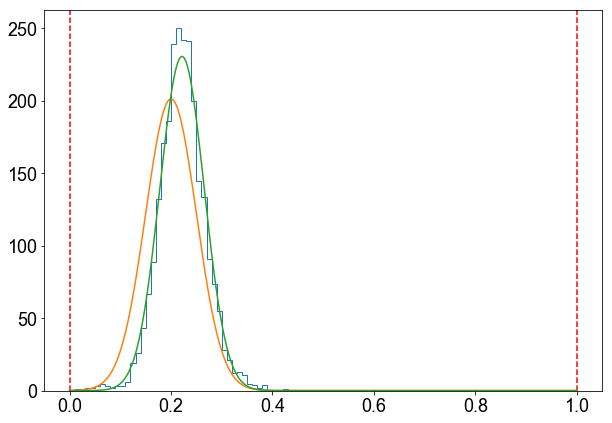

[  2.41148184e-01   4.39795168e-02   1.63172016e-04]


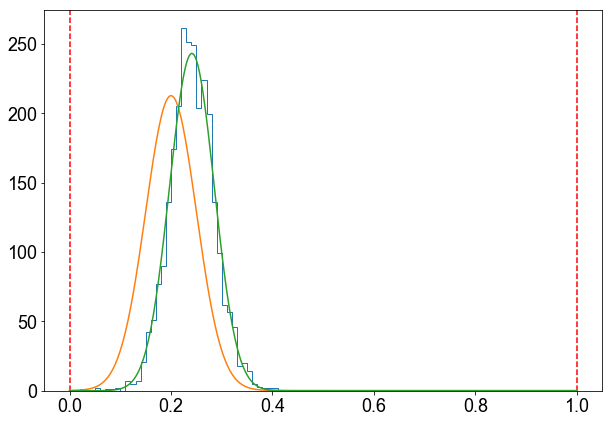

[ 0.25934739  0.04423746  0.00067925]


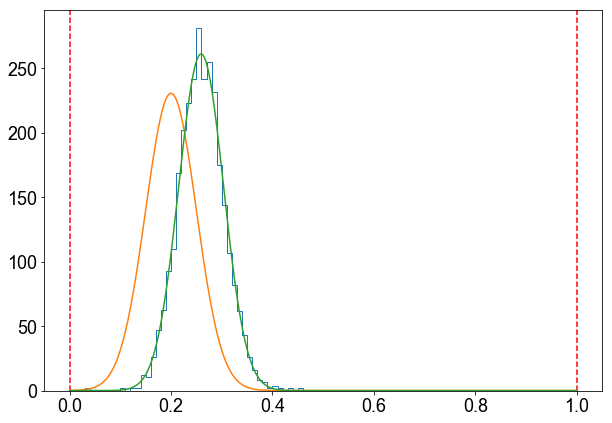

[ 0.28016854  0.0462311   0.00079478]


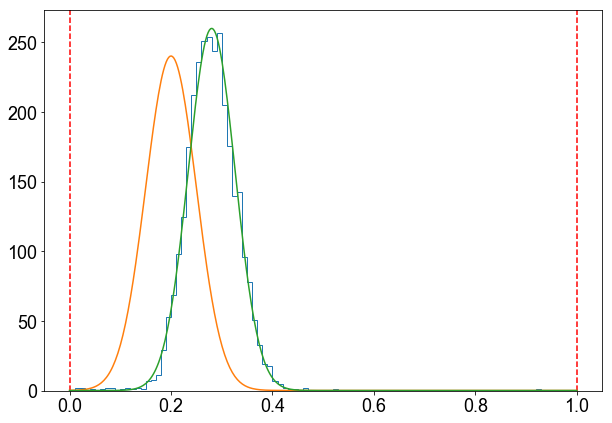

[  3.02146029e-01   4.76907154e-02   2.18010847e-04]


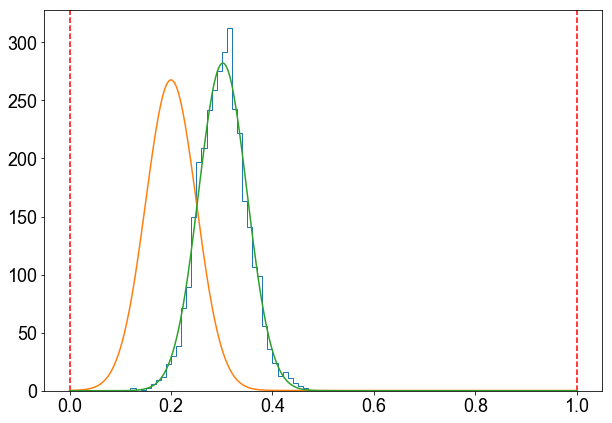

[ 0.31974505  0.04694601  0.00064197]


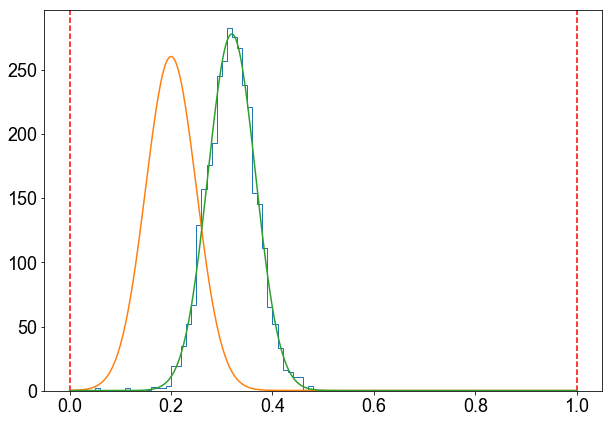

[ 0.33790129  0.04838432  0.00086322]


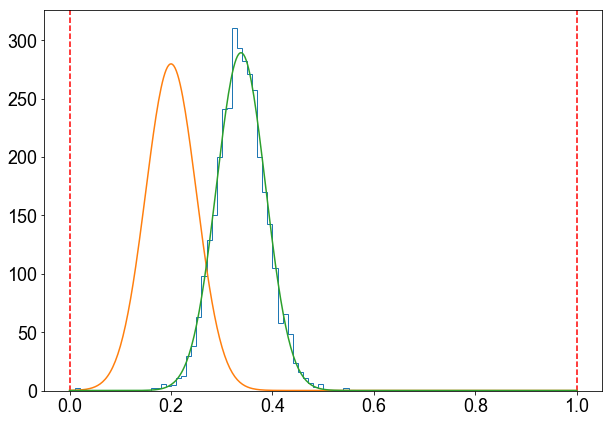

[ 0.35619367  0.04952807  0.0003724 ]


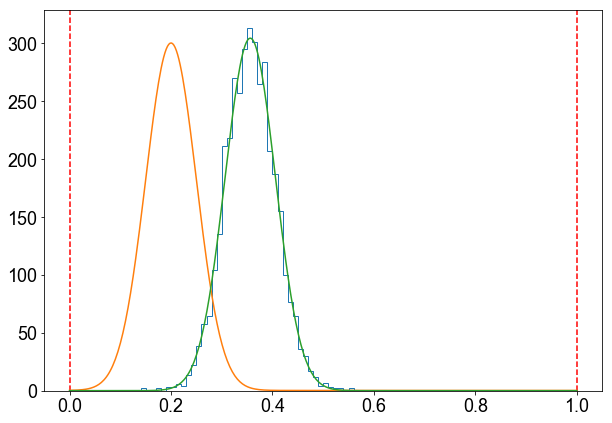

[  3.74089932e-01   5.03680437e-02   8.89054716e-05]


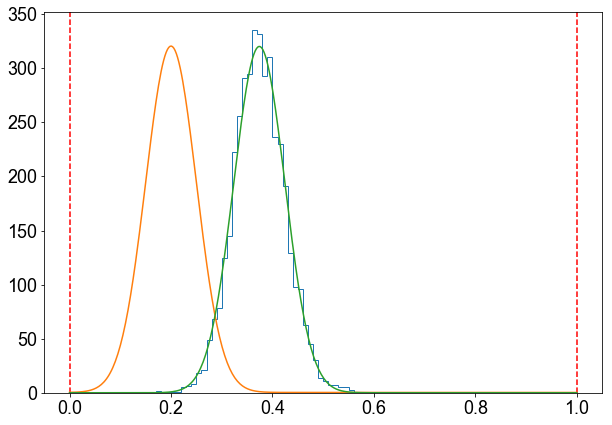

[  3.90101614e-01   4.90755456e-02   2.13585496e-04]


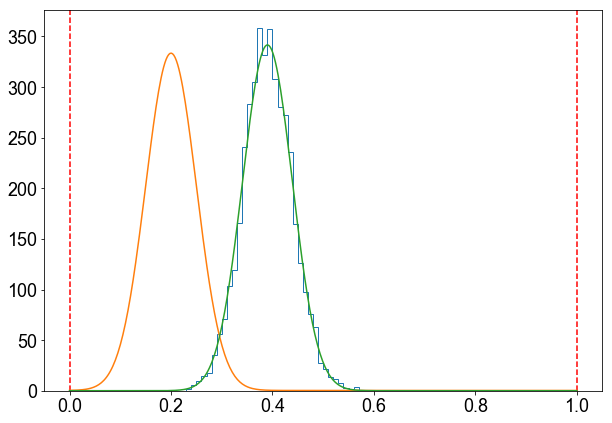

[ 0.40609598  0.0496924   0.00070329]


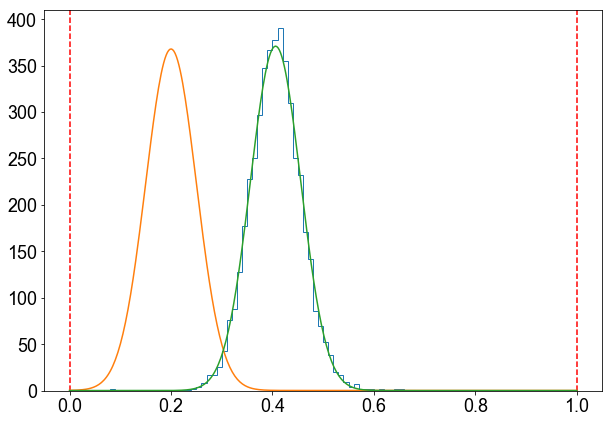

[ 0.41813508  0.05133995  0.00060927]


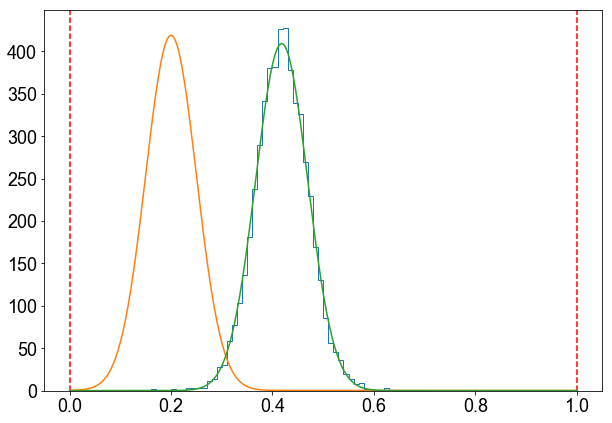

In [122]:
z_slices = np.linspace(-9.5, -0.5, 19)
z_centers = 0.5 * (z_slices[1:] + z_slices[:-1])
fit_params = []
for l, r in zip(z_slices[:-1], z_slices[1:]):
    x = ambe_2.d['s1_area_fraction_top'][(ambe_2.d['z'] >= l) & (ambe_2.d['z'] < r) 
                                         & (ambe_2.d['s1'] > 100) & (ambe_2.d['s1'] < 300)]
    # plt.hist(x, bins=100, histtype='step', range=(0, 1))
    popt, perr, _ = fit_unbinned(x, gaus_bg, (0.2, 0.05, 0.001), fit_range=(0, 1), p0_error=[1., 1., 0.1], 
                              plot = True, print_level=0, limit_x0 = (0, 1), limit_x1 = (0, 0.3), limit_x2=(0, 0.01))
    print(popt)
    fit_params.append(np.concatenate([popt, perr]))
    plt.show()

In [123]:
fit_params = np.array(fit_params)

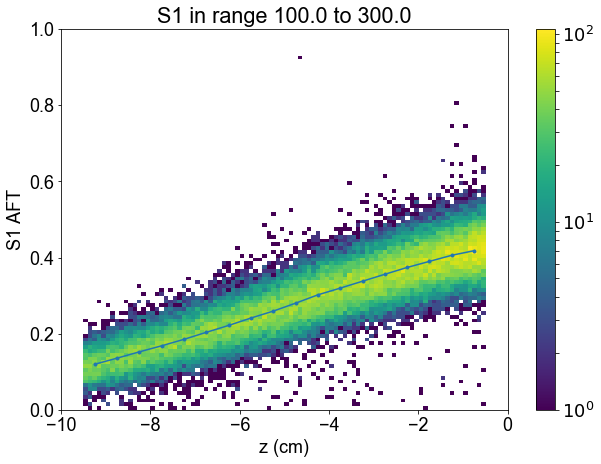

In [124]:
sel = (ambe_2.d['s1'] >= 100.) & (ambe_2.d['s1'] < 300) 
plt.hist2d(ambe_2.d['z'][sel], ambe_2.d['s1_area_fraction_top'][sel], 
           bins=100, range=((-10,0), (0, 1)), norm=LogNorm())
plt.colorbar()
plt.ylabel('S1 AFT')
plt.xlabel('z (cm)')
plt.title('S1 in range %.1f to %.1f' % (100, 300))

plt.plot(z_centers, fit_params[:, 0], marker='.')
plt.show()

In [125]:
f_s1_posrec = scipy.interpolate.interp1d(fit_params[:, 0], z_centers, 
                                         kind='linear', bounds_error=False, fill_value='extrapolate')

In [127]:
with open('f_s1_posrec.pickle', 'wb') as f:
    pickle.dump((fit_params[:, 0], z_centers), f)

### Combine data and add waveforms

Why together, you ask? Because you want to add the waveforms exactly once. So, the definion of `er` must be after the adding of the waveforms

In [128]:
# Combine data for same sources
na = combine_frameworks(na_0, na_1)
ambe = combine_frameworks(ambe_1, ambe_2)

In [129]:
# Add waveforms... This step may take a while (especially if cache files need to be build)
# time_before = time.time()
# ambe.add_s1_waveforms()
# bg.add_s1_waveforms()
# cs.add_s1_waveforms()
# na.add_s1_waveforms()
# time_after = time.time()
# print('Computation took %.1f seconds' % (time_after - time_before))

In [130]:
nr = ambe
er = combine_frameworks([bg, cs, na])

### Band fit

In [131]:
er_band_full = fit_band(er.d, 0, 400, 40, 'progressive', 1.5, mu_guess = 2e3, sigma_guess = 1e3, 
                        limit_x0 = (100, 80e3), limit_x1 = (100, 30e3))
er_band_full_p  = process_band(er_band_full)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


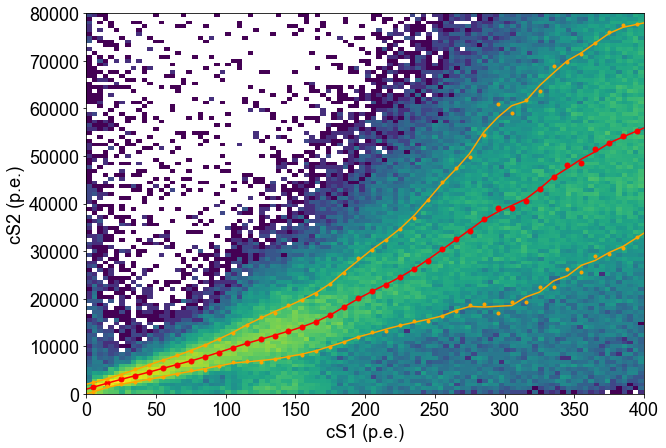

In [132]:
plot_raw_band(er_band_full, ls='None')
# plot_processed_band(er_band_p, cs1_range=(0, 400))
plot_processed_band(er_band_full_p, cs1_range=(0, 400))
er.plot_cs1cs2(bins = 100, norm=LogNorm(), range=((0, 400), (0, 80e3)))

In [133]:
er_band = fit_band(er.d, 0, 200, 20, 'progressive', 1.5, mu_guess = 2e3, sigma_guess = 1e3)
er_band_na = fit_band(na.d, 0, 200, 20, 'progressive', 1.5, mu_guess = 2e3, sigma_guess = 1e3)
er_band_cs = fit_band(cs.d, 0, 200, 20, 'progressive', 1.5, mu_guess = 2e3, sigma_guess = 1e3)
er_band_bg = fit_band(bg.d, 0, 200, 20, 'progressive', 1.5, mu_guess = 2e3, sigma_guess = 1e3)
nr_band = fit_band(nr.d, 0, 200, 20, 'progressive', 1., mu_guess = 2e3, sigma_guess = 1e3,
                  limit_x0 = (0, 4e3), limit_x1 = (200, 1e3))

nr_band_p = process_band(nr_band)
er_band_p = process_band(er_band)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


In [134]:
def plot_e_line_mod(e, pickle_file = '/home/erik/win/xams/analysis/light_yield/data/doke_sel2.pickle',
                s1_range=(0,2e3), y_axis = 'cs2b', s2_aft = None, **kwargs):
    popt_doke = pickle.load(open(pickle_file, 'rb'))
    g1, g2 = popt_doke
    x_plot = np.linspace(*s1_range, num = 100)
    if y_axis == 'cs2b':
        y_plot = g2 * (e / 13.7e-3 - x_plot / g1)
    elif y_axis == 'cs2':
        y_plot = g2 * (e / 13.7e-3 - x_plot / g1) * 1 / (1 - s2_aft)
    plt.plot(x_plot, y_plot, **kwargs)
    return

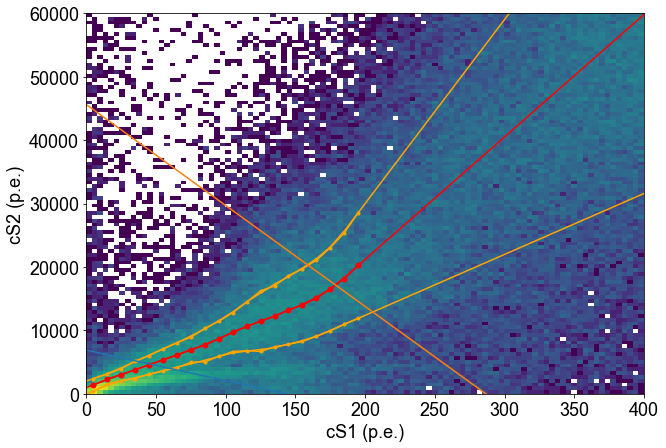

In [135]:
# plot_raw_band(er_band_na)
# plot_raw_band(er_band_cs)
# plot_raw_band(er_band_bg)
plot_raw_band(er_band)
plot_processed_band(er_band_p, cs1_range=(0, 400))
ambe_2.plot_cs1cs2(bins = 100, norm=LogNorm(), range=((0, 400), (0, 60e3)))
er.plot_e_line(20)
plot_e_line_mod(40, y_axis='cs2', s2_aft = 0.698)

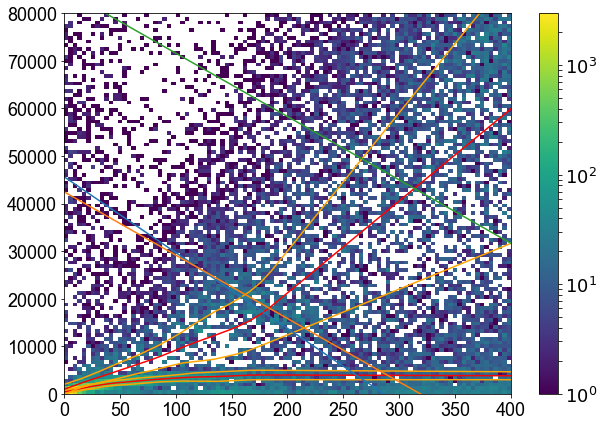

In [136]:
# plt.set_cmap('RdBu_r')
# plot_dfs_diffs(nr, bg, range=((0, 200), (0, 30e3)), bins=100, vmin=-30, vmax = 30)
plt.set_cmap('viridis')
plot_dfs_diffs(nr, bg, range=((0, 400), (0, 80e3)), bins=100, norm=LogNorm())
plt.colorbar()
# plot_raw_band(nr_band)
plot_processed_band(nr_band_p)
plot_processed_band(er_band_p, cs1_range=(0, 400))
plot_e_line_mod(40, y_axis='cs2', s2_aft = 0.698)
plot_e_line_mod(40, y_axis='cs2', s2_aft = 0.698, pickle_file='../light_yield/data/doke_sel2_ext.pickle')
plot_e_line_mod(80, y_axis='cs2', s2_aft = 0.698, pickle_file='../light_yield/data/doke_sel2_ext.pickle')

### Apply selection

In [170]:
nr_nrsel = cut_band(nr, nr_band_p)
nr_ersel = cut_band(nr, er_band_p)
er_ersel = cut_band(er, er_band_p)
bg_nrsel = cut_band(bg, nr_band_p)
bg_ersel = cut_band(bg, er_band_p)

In [171]:
ambe_1_nrsel = cut_band(ambe_1, nr_band_p)
ambe_2_nrsel = cut_band(ambe_2, nr_band_p)
ambe_1_ersel = cut_band(ambe_1, er_band_p)
ambe_2_ersel = cut_band(ambe_2, er_band_p)

In [172]:
df_selection_list = [nr_nrsel, nr_ersel, er_ersel, bg_nrsel, bg_ersel, ambe_1_nrsel, ambe_2_nrsel,
                    ambe_1_ersel, ambe_2_ersel]

In [173]:
for x in df_selection_list:
    x.add_g1g2_props(pickle_file='../light_yield/data/doke_sel2_ext.pickle') # 'data/doke_sel2_ext.pickle

### Inspect cS1 spectrum

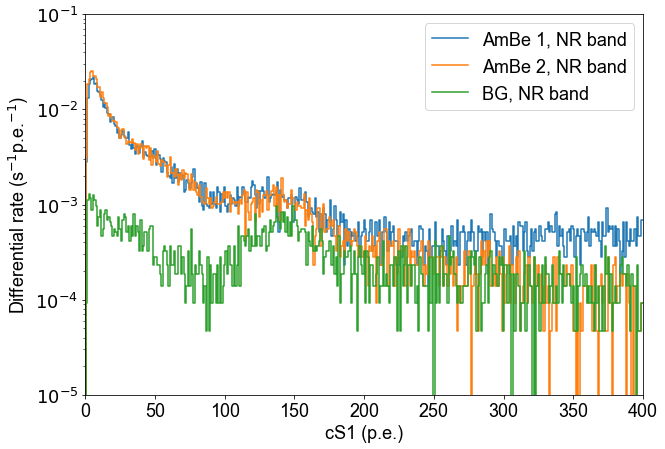

In [174]:
ambe_1_nrsel.plot_cs1_rate(label='AmBe 1, NR band')
ambe_2_nrsel.plot_cs1_rate(label='AmBe 2, NR band')
# nr_nrsel.plot_cs1_rate(label='AmBe, NR band')
bg_nrsel.plot_cs1_rate(label='BG, NR band')
plt.legend()
plt.ylim(1e-5, 1e-1)
plt.yscale('log')
plt.xlim(0, 400)
plt.show()

#### CES

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


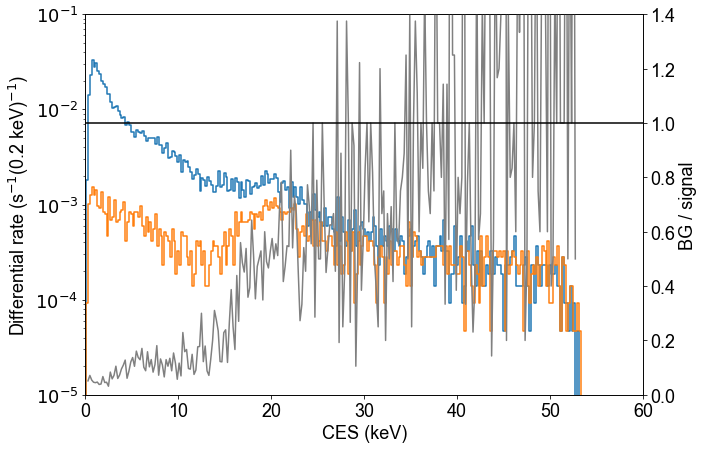

In [180]:
ces_max =60
e_bins, counts_nr = ambe_2_nrsel.plot_ces_rate(bin_width=0.2, ces_max=ces_max, label='AmBe 2 NR selection')
_, counts_bg      = bg_nrsel.plot_ces_rate(bin_width=0.2, ces_max=ces_max, label='BG NR selection')
plt.yscale('log')
plt.ylim(0.00001, 1e-1)
plt.legend()
plt.twinx()
plt.plot(e_bins, counts_bg/ counts_nr, color='gray')
plt.ylim(0, 1.4)
plt.ylabel('BG / signal')
plt.xlim(0, ces_max)
plt.axhline(1, color='black')
plt.title
plt.show()

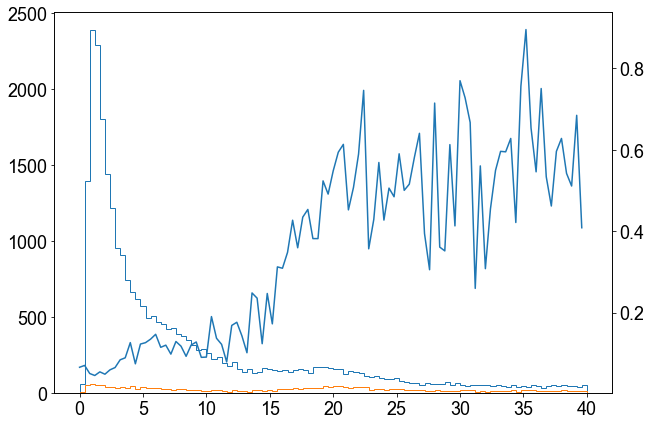

In [147]:
ran  = (0, 40)
counts_nr, edges , _ = plt.hist(nr_nrsel.d['e_ces'], bins=100, histtype='step', range=ran)
counts_bg, _, _ = plt.hist(bg_nrsel.d['e_ces'], bins=100, histtype='step', range=ran)
plt.twinx()
plt.plot(edges[:-1], 2 * counts_bg  /counts_nr)
plt.show()

In [148]:
ambe_1_nrsel.add_g1g2_props(pickle_file='../light_yield/data/doke_sel2_ext.pickle')
ambe_2_nrsel.add_g1g2_props(pickle_file='../light_yield/data/doke_sel2_ext.pickle')

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


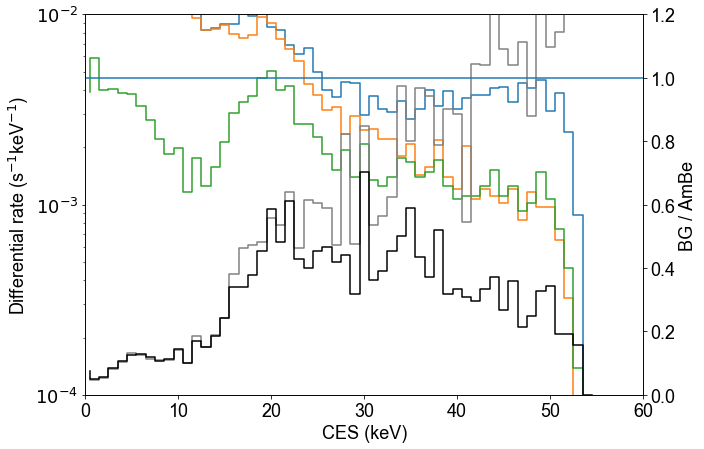

In [149]:
ces_max = 60
bin_width = 1
e, ambe_1_counts = ambe_1_nrsel.plot_ces_rate(ces_max = ces_max, bin_width = bin_width, label='AmBe 1')
e, ambe_2_counts = ambe_2_nrsel.plot_ces_rate(ces_max = ces_max, bin_width = bin_width, label='AmBe 2')
e, bg_counts = bg_nrsel.plot_ces_rate(ces_max = ces_max, bin_width = bin_width, label='BG')
plt.yscale('log')
plt.ylim(0.0001, 0.01)
plt.legend()
plt.twinx()
plt.plot(e, bg_counts / ambe_2_counts, color='gray', ls='steps')
plt.plot(e, bg_counts / ambe_1_counts, color='black', ls='steps')
plt.ylim(0, 1.2)
plt.axhline(1)
plt.xlim(0, ces_max)
plt.ylabel('BG / AmBe')
plt.show()

(0, 60)

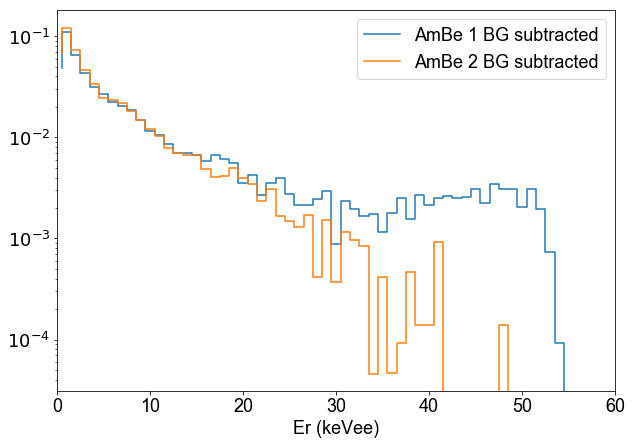

In [155]:
plt.plot(e, ambe_1_counts - bg_counts, ls='steps', label='AmBe 1 BG subtracted')
plt.plot(e, ambe_2_counts - bg_counts, ls='steps', label='AmBe 2 BG subtracted')
plt.xlabel('Er (keVee)')
plt.axhline(0, color='black')
# plt.ylim(-10, 100)
plt.yscale('log')
plt.legend()
plt.xlim(0, 60)
#plt.ylim(0.5, 1e4)

### ER comparison and the inelastic line...

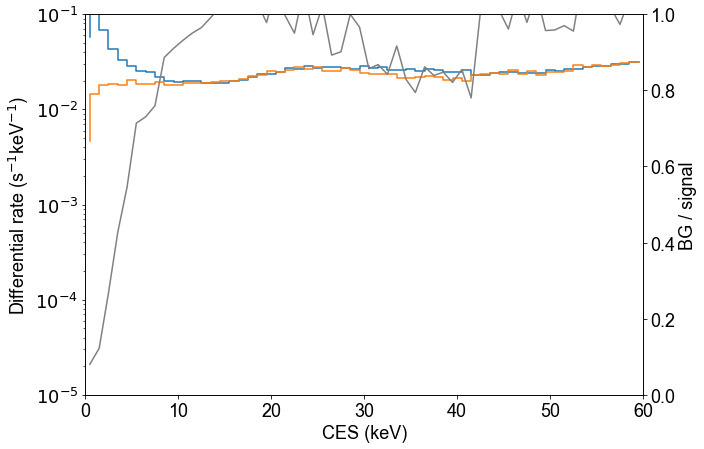

In [158]:
ces_max = 60
bin_width = 1
e_bins, counts_nr = nr_ersel.plot_ces_rate(bin_width=bin_width, ces_max=ces_max)
_, counts_bg      = bg_ersel.plot_ces_rate(bin_width=bin_width, ces_max=ces_max)
plt.yscale('log')
plt.ylim(0.00001, 1e-1)
plt.twinx()
plt.plot(e_bins, counts_bg/ counts_nr, color='gray')
plt.ylim(0, 1)
plt.ylabel('BG / signal')
plt.xlim(0, ces_max)

plt.show()

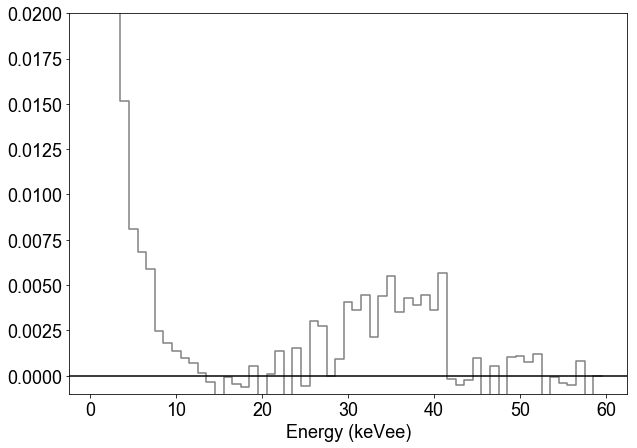

In [161]:
plt.plot(e_bins, counts_nr -  counts_bg, color='gray', ls='steps')
plt.ylim(-1e-3, 0.02)
plt.axhline(0, color='black')
plt.xlabel('Energy (keVee)')

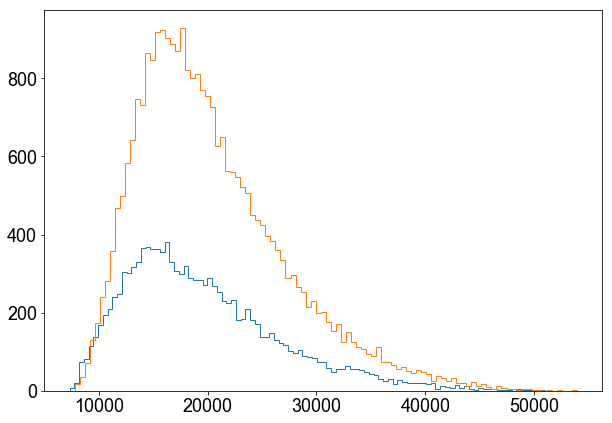

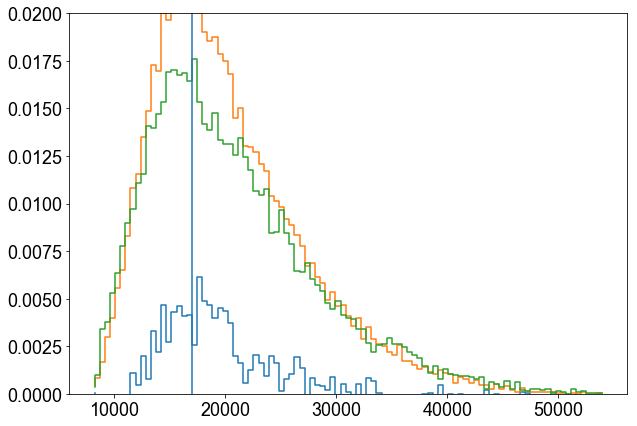

In [255]:
sel = (bg_ersel.d['e_ces'] > 25) & (bg_ersel.d['e_ces'] < 50)
count_bg, edges, _ = plt.hist(bg_ersel.d['cs2'][sel], bins=100, histtype='step')
sel = (nr_ersel.d['e_ces'] > 25) & (nr_ersel.d['e_ces'] < 50)
count_nr, edges, _ = plt.hist(nr_ersel.d['cs2'][sel], bins=100, histtype='step')
plt.show()

plt.plot(edges[1:], count_nr / nr.livetime - count_bg / bg.livetime , ls='steps')
plt.plot(edges[1:], count_nr / nr.livetime , ls='steps')
plt.plot(edges[1:], count_bg / bg.livetime , ls='steps')
# plt.xlim(0, 200)
plt.ylim(0, 0.02)
plt.axvline(17e3)
plt.show()

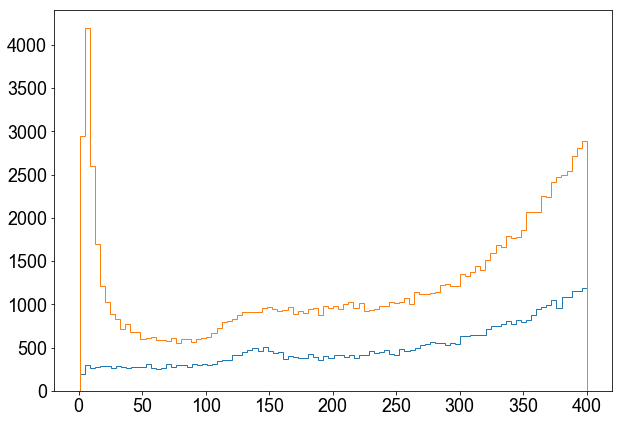

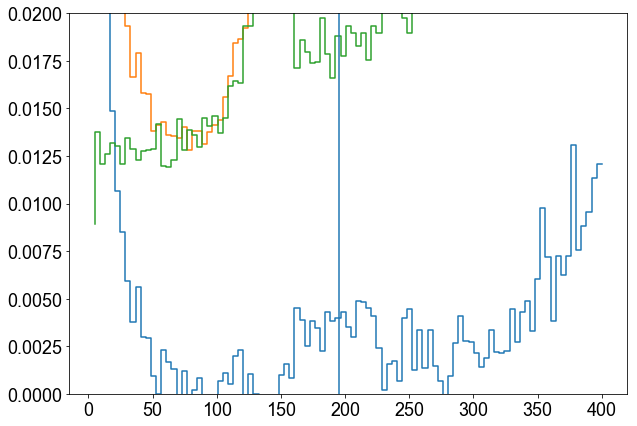

In [256]:
sel = (bg_ersel.d['e_ces'] > 25) & (bg_ersel.d['e_ces'] < 50)
count_bg, edges, _ = plt.hist(bg_ersel.d['cs1'], bins=100, histtype='step')
sel = (nr_ersel.d['e_ces'] > 25) & (nr_ersel.d['e_ces'] < 50)
count_nr, edges, _ = plt.hist(nr_ersel.d['cs1'], bins=100, histtype='step')
plt.show()

plt.plot(edges[1:], count_nr / nr.livetime - count_bg / bg.livetime , ls='steps')
plt.plot(edges[1:], count_nr / nr.livetime , ls='steps')
plt.plot(edges[1:], count_bg / bg.livetime , ls='steps')
# plt.xlim(0, 200)
plt.ylim(0, 0.02)
plt.axvline(195)
plt.show()

In [237]:
np.average(nr_ersel.d['s2_area_fraction_top'])

0.69820512677778424

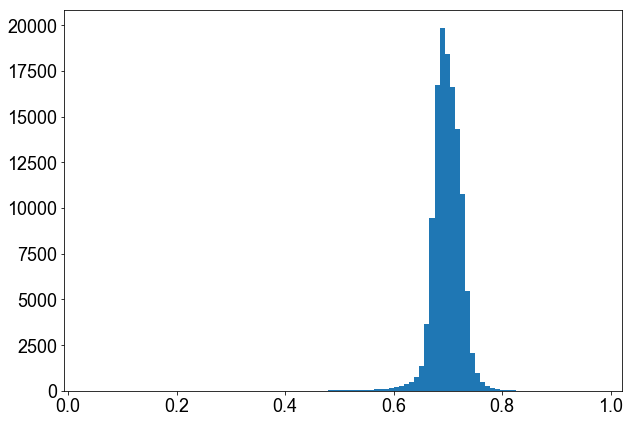

In [236]:
plt.hist(nr_ersel.d['s2_area_fraction_top'], bins=100)
plt.show()

There is nothing wrong with the analysis or the scaling (note: to be implemented on next run): the ER contributions are similar for BG and NR if we are far away from the band. There is a hint of a 35 keV (40 keVee from inelastic line?!?!). The NR band contributions are NOT the same at high energies: they should converge at high enough energies, but they stay a factor of ~ 2 off.

So... Is there more leakage in the NR band then? Well maybe it's time-dependent, right? Let's look at a troublesome region: 

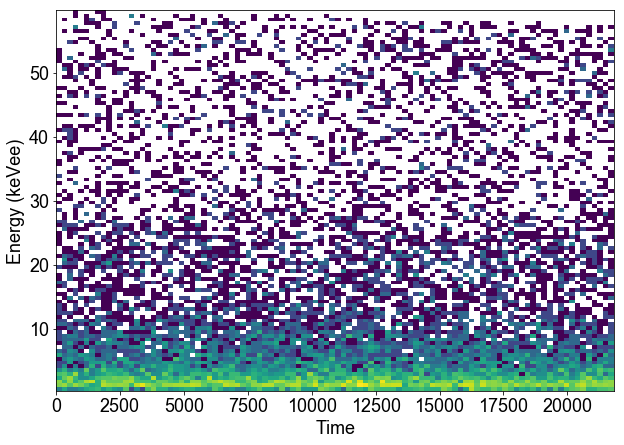

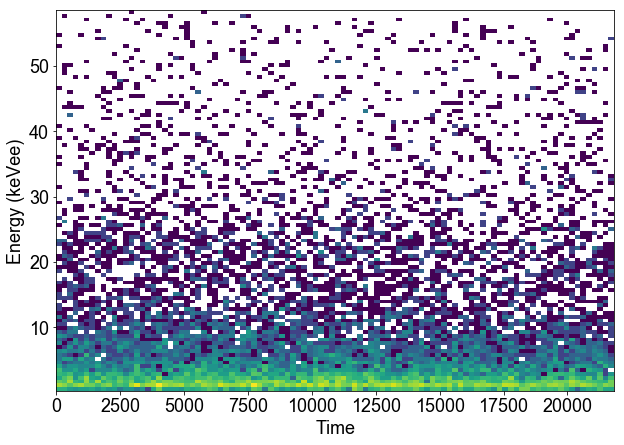

In [159]:

plt.hist2d(ambe_1_nrsel.d['t'], ambe_1_nrsel.d['e_ces'], bins=100, norm=LogNorm())
plt.xlabel('Time')
plt.ylabel('Energy (keVee)')
plt.show()


plt.hist2d(ambe_2_nrsel.d['t'], ambe_2_nrsel.d['e_ces'], bins=100, norm=LogNorm())
plt.xlabel('Time')
plt.ylabel('Energy (keVee)')
plt.show()

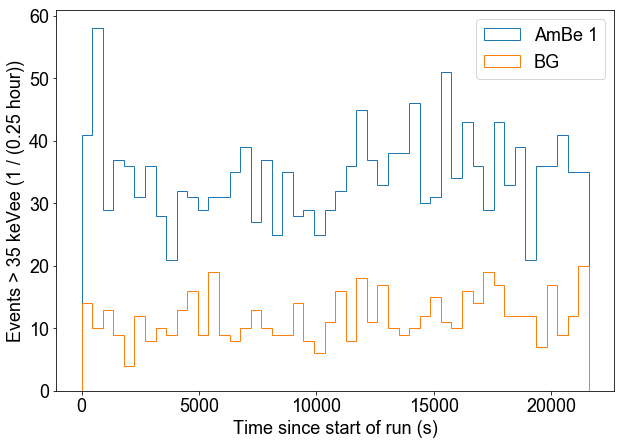

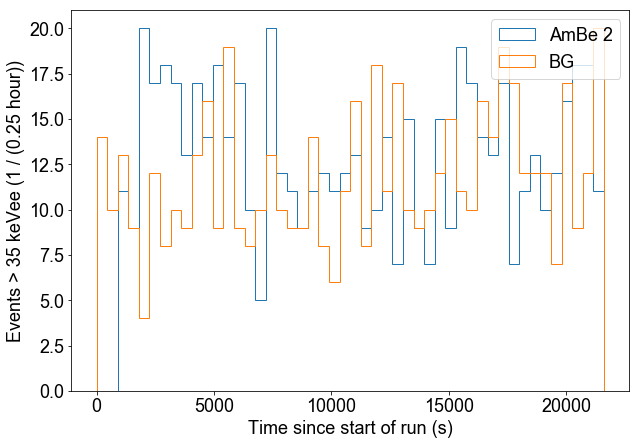

In [135]:
highband = (nr_nrsel.d['e_ces'] > 35) & (nr_nrsel.d['run_number'] <= 24)
bins = 48
ran = (0, 3600 * 6)
plt.hist(nr_nrsel.d['t'][highband], histtype='step', bins=bins,range=ran, label='AmBe 1')
highband = bg_nrsel.d['e_ces'] > 35
plt.hist(bg_nrsel.d['t'][highband], histtype='step', bins=bins,range=ran, label='BG')
plt.legend()
plt.xlabel('Time since start of run (s)')
plt.ylabel('Events > 35 keVee (1 / (0.25 hour))')
plt.show()

highband = (nr_nrsel.d['e_ces'] > 35) & (nr_nrsel.d['run_number'] > 24)
bins = 48
ran = (0, 3600 * 6)
plt.hist(nr_nrsel.d['t'][highband], histtype='step', bins=bins,range=ran, label='AmBe 2')
highband = bg_nrsel.d['e_ces'] > 35
plt.hist(bg_nrsel.d['t'][highband], histtype='step', bins=bins,range=ran, label='BG')
plt.legend()
plt.xlabel('Time since start of run (s)')
plt.ylabel('Events > 35 keVee (1 / (0.25 hour))')
plt.show()

Aha! It's not time-dependent, it's *run*-dependent

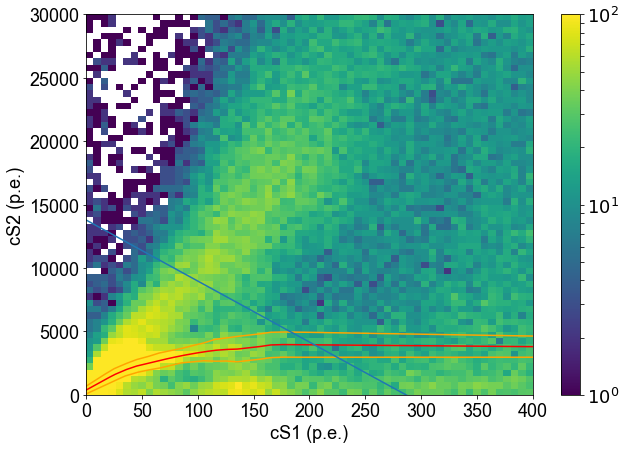

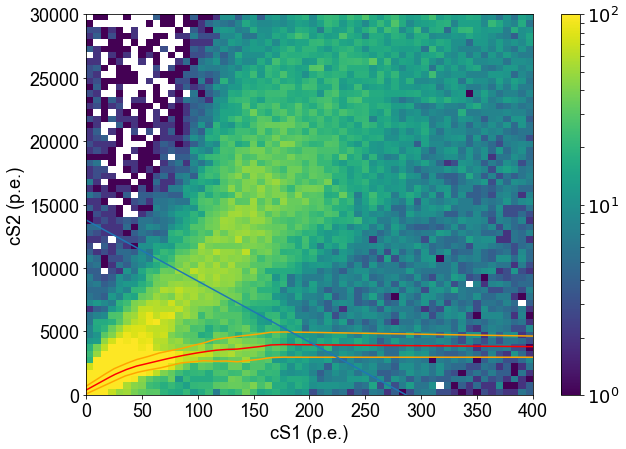

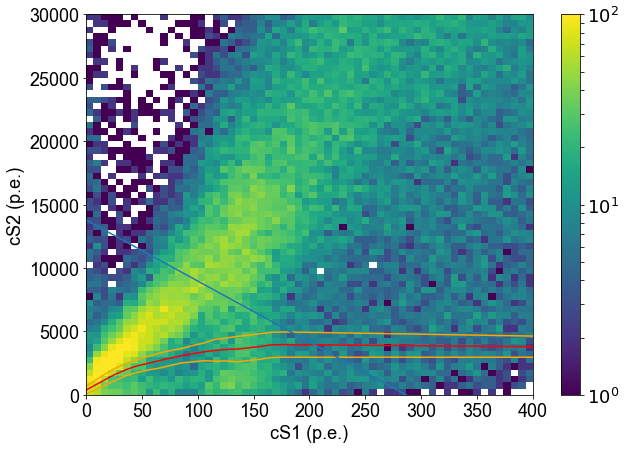

In [171]:
for x in [ambe_1, ambe_2, bg]:
    x.plot_cs1cs2(bins=60, norm=LogNorm(), range=((0, 400), (0, 30e3)), vmax=100)
    plot_processed_band(nr_band_p, cs1_range=(0, 400))
    plt.colorbar()
    x.plot_e_line(40)
    plt.show()

Solution: select only the second dataset?...

### Pulses

#### Functions

In [236]:
# def integrate_until_fraction(w, area_tot, fractions_desired, results):
#     """For array of fractions_desired, integrate w until fraction of area is reached, place sample index in results
#     Will add last sample needed fractionally.
#     eg. if you want 25% and a sample takes you from 20% to 30%, 0.5 will be added.
#     Assumes fractions_desired is sorted and all in [0, 1]!
#     This function is stolen and modified from Pax - Erik Hogenbirk September 2017
#     """
#     fraction_seen = 0
#     current_fraction_index = 0
#     needed_fraction = fractions_desired[current_fraction_index]
#     for i, x in enumerate(w):
#         # How much of the area is in this sample?
#         fraction_this_sample = x/area_tot
#         # Will this take us over the fraction we seek?
#         # Must be while, not if, since we can pass several fractions_desired in one sample
#         while fraction_seen + fraction_this_sample >= needed_fraction:
#             # Yes, so we need to add the next sample fractionally
#             area_needed = area_tot * (needed_fraction - fraction_seen)
#             if x != 0:
#                 results[current_fraction_index] = i + area_needed/x
#             else:
#                 results[current_fraction_index] = i
#             # Advance to the next fraction
#             current_fraction_index += 1
#             if current_fraction_index > len(fractions_desired) - 1:
#                 return
#             needed_fraction = fractions_desired[current_fraction_index]
#         # Add this sample's area to the area seen, advance to the next sample
#         fraction_seen += fraction_this_sample
#     if needed_fraction == 1:
#         results[current_fraction_index] = len(w)
#     else:
#         return -1

In [260]:
# def add_percentiles(d, fractions_desired = [0.1, 0.2, 0.3, 0.4]):
#     '''
#     Compute the point in the S1 waveform where 10, 20, 30 and 40 percent of the area is reached.
#     Adds properties to the dataframe: `s1_X0p_point` and `s1_fraction_outside_pulse`.
#     Time in ns since start of pulse (pulse[0] = 0 ns)
#     '''
#     s1_percentile_points = []
#     s1_area_fraction_outside_pulse = []
    
#     for i, ev in d.iterrows():
#         pulse = np.array(ev['s1_pulse'])
#         area_times = np.ones(4) * float('nan')
#         area_tot = ev['s1']
#         return_status = integrate_until_fraction(
#             pulse, area_tot, fractions_desired=fractions_desired, results=area_times)
#         if return_status == -1:
#             print('Warning: fraction not reached in event %d of run %d' % (ev['event_number'], 
#                                                                           ev['run_number']))
#         s1_percentile_points.append(2. * area_times) # Correct for 2 ns here
#         s1_area_fraction_outside_pulse.append(1 - np.sum(pulse) / ev['s1'])
        
#     s1_percentile_points = np.array(s1_percentile_points)
#     for i, fraction in enumerate(fractions_desired):
#         d['s1_%d_percentile_point' % (fraction * 100)] = s1_percentile_points[:, i]        
#     d['s1_fraction_outside_pulse'] = s1_area_fraction_outside_pulse
#     return 
        

def build_pulse_hist_entries(d, alignment_field):
    '''
    Align the S1 pulses. This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    The function returns two arrays, one containing the time points (shifted by the alignment field) and 
    one containing the weight, so that lower-than 1 bin sampling and alignment is possible.
    '''
    time_edges = np.linspace(-100, 300, 201)
    # Arbitrarily put the first sample EXACTLY at zero rather than at bin edges
    time = time_edges[:-1]
    time_entries = []
    weight_entries = []
    
    for i, ev in d.iterrows():
        time_entries.append(time + 100 - ev[alignment_field])
        weight_entries.append(np.array(ev['s1_pulse']) / ev['s1'])
    
    return np.concatenate(time_entries), np.concatenate(weight_entries)

def compute_average_pulse(d, alignment_field, dt = 2):
    '''
    Compute the average pulse, calling the underlying `build_pulse_hist_entries` routine. 
    This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    dt is sample time in ns, which may be lower than the raw sample of 2 ns. Go ahead and try!
    '''
    n_bins_time = np.floor(400 / dt) + 1
    if 400 % dt:
        print('Warning: please use a divisor of 400 for your time bins (i.e. 1, 0.2, 200, ...) .')
    time_edges = np.linspace(-100, 300, n_bins_time)
    times, weights = build_pulse_hist_entries(d, alignment_field)
    
    # This takes only the left bin edges, so that the first sample is zero.
    time = time_edges[:-1]
    amplitude, _ = np.histogram(times, bins=time_edges, weights=weights)
    # Normalization
    amplitude = amplitude / len(d) / dt
    
    return time, amplitude

def plot_average_pulse_in_slice(d, alignment_field, dt = 2, cs1_range=(0, np.inf), **kwargs):
    sel = (d['cs1'] >= cs1_range[0]) & (d['cs1'] < cs1_range[1])
    time, average_pulse = compute_average_pulse(d[sel], alignment_field, dt)
    plt.plot(time, average_pulse, **kwargs)
    plt.xlabel('Time (ns)')
    plt.ylabel('Average pulse ((%d ns)$^{-1}$)' % dt)
    return 

#### Compare!

This should be done in the XAMSAnalysis object now. 

In [261]:
# # This adds the percentiles based on the pulse waveform...
# for x in [nr_nrsel, nr_ersel, er_ersel, bg_nrsel]:
#     x.add_percentiles()
#     # add_percentiles(x.d)

In [239]:
# def add_percentiles_from_pax(d, fractions_desired = [0.1, 0.2, 0.3, 0.4]):
#     '''
#     Compute the position in ns in the waveform where a certain fraction of the area is reached. Should give the same as 
#     add_percentiles!
#     '''
#     for frac in fractions_desired:
#         pct = frac * 100
#         shift_from_midpoint = d['s1_time_from_midpoint_%dp' % pct]
#         shift_error = d['s1_center_time'] - round(d['s1_center_time'] / 2) * 2
#         shift_from_center_to_midpoint = d['s1_area_midpoint'] - d['s1_center_time']
#         d['s1_%d_percentile_point_pax' % pct] = 100 + shift_from_center_to_midpoint + shift_from_midpoint + shift_error
#     return


In [258]:
for x in [nr_nrsel, nr_ersel, er_ersel, bg_nrsel]:
    x.add_percentiles()
    # add_percentiles_from_pax(x.d)

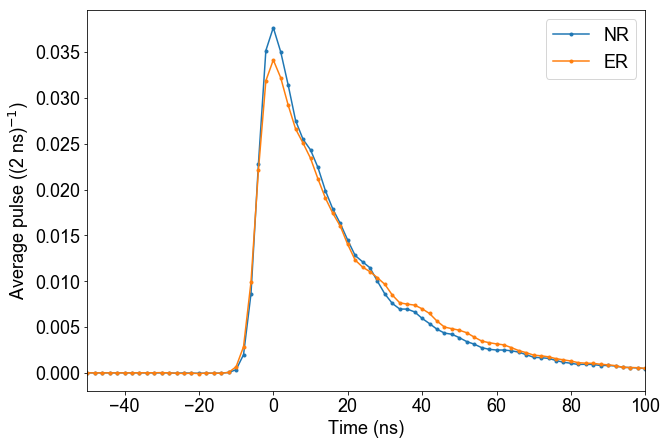

In [263]:
plot_average_pulse_in_slice(nr_nrsel.d, 's1_10_percentile_point', dt=2, cs1_range=(30, 40), label='NR', marker='.')
plot_average_pulse_in_slice(er_ersel.d, 's1_10_percentile_point', dt=2, cs1_range=(30, 40), label='ER', marker='.')

plt.xlim(-50, 100)
plt.legend()
# plt.yscale('log')
plt.show()

### Dump objects to file

In [247]:
pickle.dump((nr_nrsel.d, er_ersel.d, bg_nrsel.d), open('highfield_dataframes.pickle', 'wb'))

In [ ]:
0/0

# Low field data

### Load data

In [264]:
reload_all = False
ambe_l = read_and_cut(run_names_ambe_low, processed_data_path, minitree_path, treemakers = treemakers, 
                      pickle_file = '/home/erik/win/data/xams_run8/ambe_l.pickle', config='lowfield',
                      force_reload = reload_all)
cs_l = read_and_cut(run_names_cs_low, processed_data_path, minitree_path, treemakers = treemakers, 
                      pickle_file = '/home/erik/win/data/xams_run8/cs_l.pickle', config='lowfield',
                      force_reload = reload_all)

Read 35964 events from file /home/erik/win/data/xams_run8/ambe_l.pickle
Read 15065 events from file /home/erik/win/data/xams_run8/cs_l.pickle


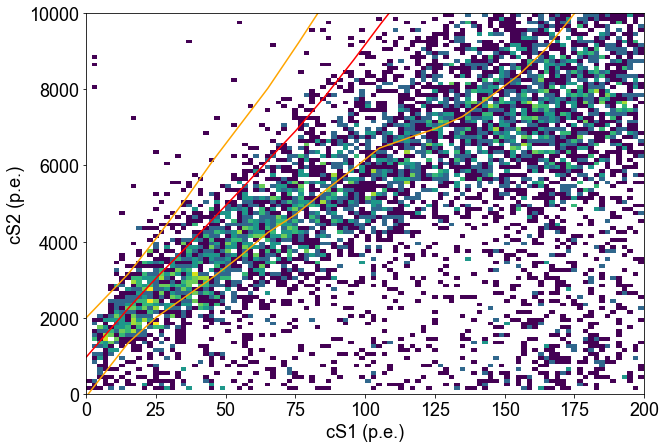

In [266]:
cs_l.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 200), (0, 10e3)))
plot_processed_band(er_band_p)
plt.show()

### S2 decrease

Yay, no decrease correction necessary! We did anode resets!

### S2 width

Parameters found:  [  3.68984591e+01   5.14312767e-07]
Diffusion is 36.90 +- 0.45 +- 0.41 cm**2 / s
Diffusion is 36.90 +- 0.61 cm**2 / s


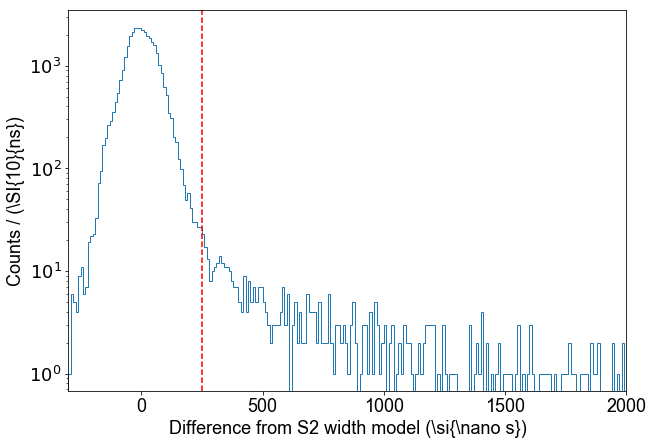

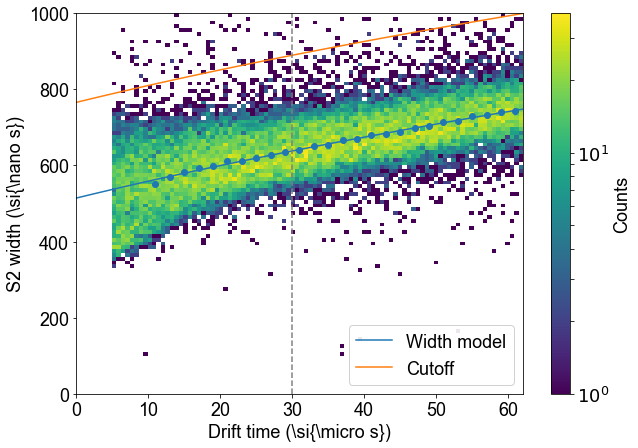

In [307]:
ambe_l.cut_s2_range_50p_area(apply=True, plot=True, dt_range=(10, 70))

Parameters found:  [  3.73138010e+01   5.10412719e-07]
Diffusion is 37.31 +- 0.43 +- 0.41 cm**2 / s
Diffusion is 37.31 +- 0.60 cm**2 / s


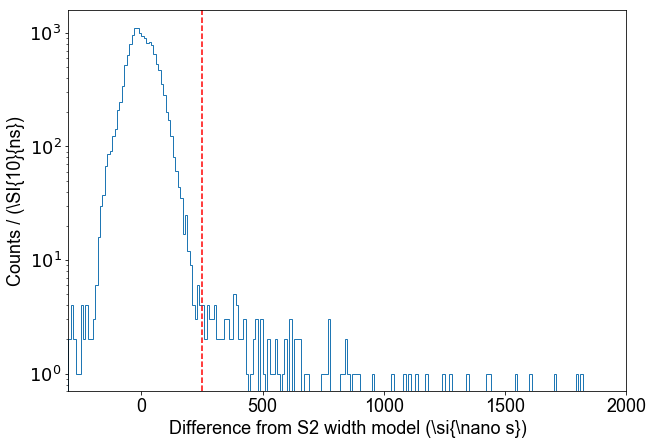

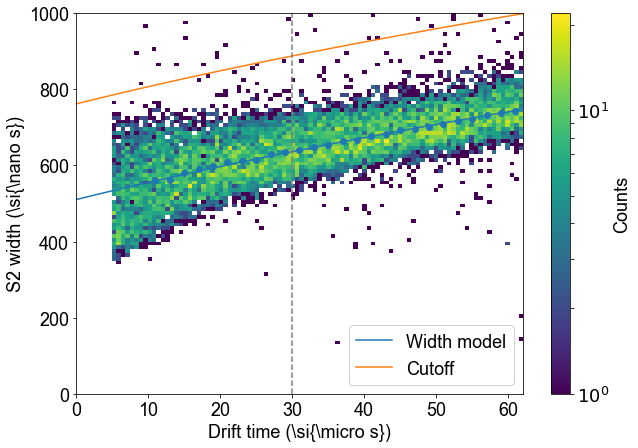

In [308]:
cs_l.cut_s2_range_50p_area(apply=False, plot=True, dt_range=(10, 70))

In [ ]:
# Parameters found:  [  3.73138010e+01   5.10412719e-07]
# Parameters found:  [  3.68984591e+01   5.14312767e-07]

### Band fit

In [328]:
er_lowfield = fit_band(cs_l.d, 0, 400, 40, mode='progressive', sigma_range=1.5, limit_x0 = (100, 30e3),
                      mu_guess = 2000, sigma_guess = 300)
er_lowfield_p = process_band(er_lowfield)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


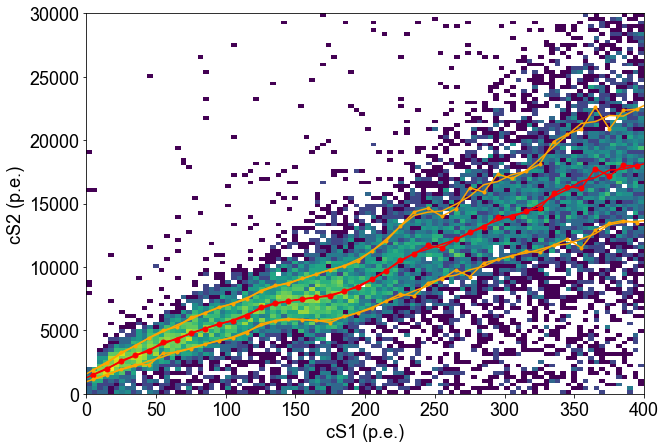

In [329]:
cs_l.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 400), (0, 30e3)))
plot_raw_band(er_lowfield)
plot_processed_band(er_lowfield_p)
plt.show()

In [341]:
nr_lowfield = fit_band(ambe_l.d, 0, 120, 12, 'progressive', 1.5, mu_guess = 200, sigma_guess = 100)
nr_lowfield_p = process_band(nr_lowfield)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


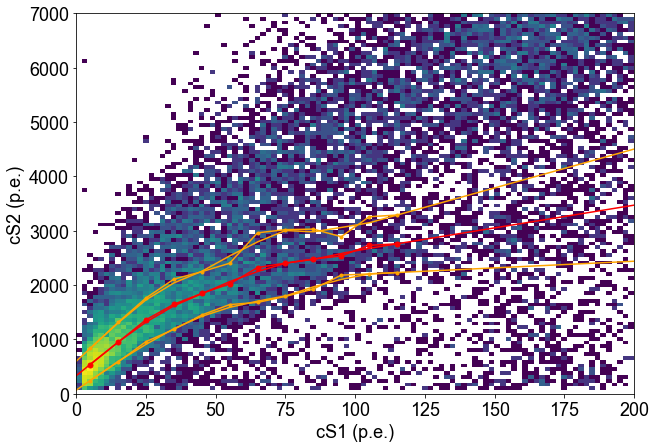

In [342]:
ambe_l.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 200), (0, 7e3)))
plot_raw_band(nr_lowfield)
plot_processed_band(nr_lowfield_p)
plt.show()

### Add waveforms

In [ ]:
ambe_l.add_s1_waveforms()

In [347]:
hax.init(
    # Always use these lines to tell hax that we don't care about Xe1T
    experiment='XAMS', 
    pax_version_policy='loose', use_runs_db = False,
    # Here come the useful settings
    main_data_paths = [processed_data_path],
    minitree_paths = [minitree_path],       
 )
        

INFO:hax.__init__] Not looking for datasets in runs, db since you put use_runs_db = False


## Open questions

  * Why does the distribution in cS1/cS2 look so different for Na22?
  * What is that population with low width?
  * Is the difference in S2 width due to a different liquid level? *YES.*
  * As the ER band rate is the same at high cS1 in AmBe/BG, why is the rate below the band higher? 
  * What is the equivalent energy in the cS1/cS2 plot? How for does the NR spectrum go?
  * What is that crap below the ER band at 150 p.e. cS1?

## Checks and secondary effects

### The Weird Population

After some careful consideration and discussion with Sander, consider the following...

There are more events below the bands than above it, suggesting that we lose S2 but not S1 (electrons lost but not photons). If the events below the band are selected, you can see that the events seem to be good, legitimate events:
- The S2 AFT is in bounds (suggesting it's a true S2)
- The S1 AFT is in agreement with the z-position (the S1-S2 pair is correct, also, probably no gamma-X)
- No time dependance

Where do we see weird things? Well, the following:
- The **S2 width is low**. This effect is isolated in the following graph.
- There is a mild bias in z.

What could it be? Most likely explanation: it is events at the edges. This would explain why we do not see it in high energy sources (Na): the low energy scatters coming from BG are probably largely due to low-energy gammas with a very low stopping power. These'll be stopped at the edges. If it is at the edges, the path through the the gas might be shorter due to the capillary effect. 

That said... It's also in the Cs data. But wait, is it also in the Na data? It could still be background...



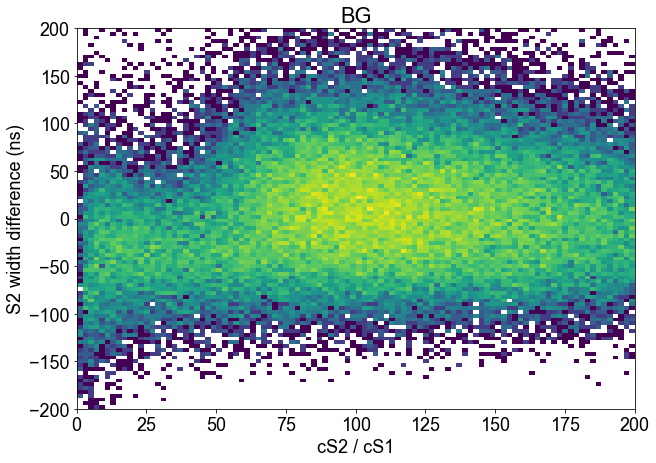

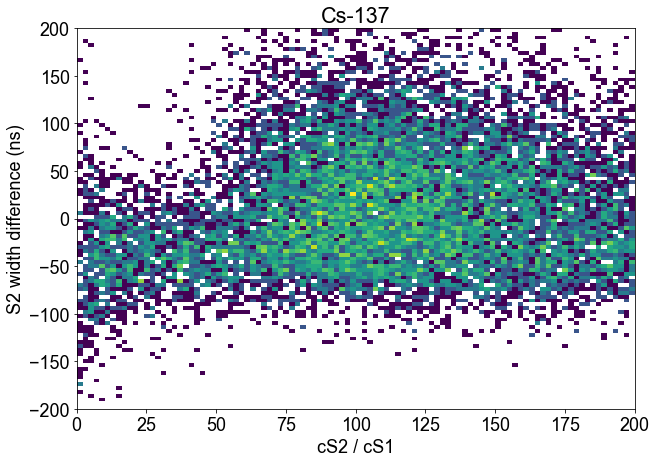

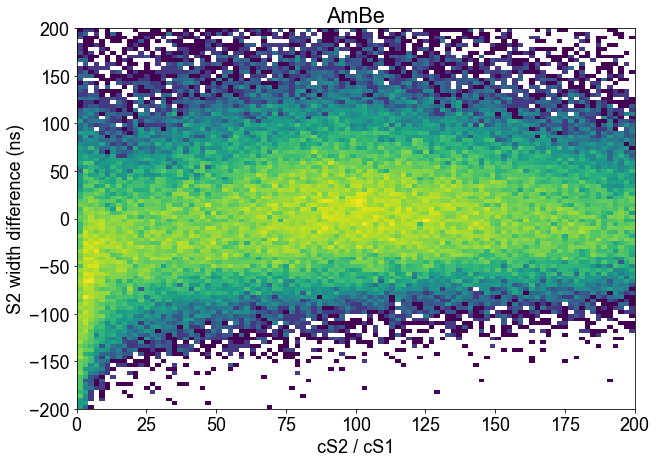

In [36]:
plt.hist2d(bg.d['cs2'] / bg.d['cs1'], bg.d['s2_width_difference'], bins=100, norm=LogNorm(),
          range=((0, 200), (-200, 200)))
plt.xlabel('cS2 / cS1')
plt.ylabel('S2 width difference (ns)')
plt.title('BG')
plt.savefig('figs/s2_width_v_ratio.png', bbox_inches='tight')
plt.show()

plt.hist2d(cs.d['cs2'] / cs.d['cs1'], cs.d['s2_width_difference'], bins=100, norm=LogNorm(),
          range=((0, 200), (-200, 200)))
plt.xlabel('cS2 / cS1')
plt.ylabel('S2 width difference (ns)')
plt.title('Cs-137')
plt.show()

plt.hist2d(ambe_1.d['cs2'] / ambe_1.d['cs1'], ambe_1.d['s2_width_difference'], bins=100, norm=LogNorm(),
          range=((0, 200), (-200, 200)))
plt.xlabel('cS2 / cS1')
plt.ylabel('S2 width difference (ns)')
plt.title('AmBe')
plt.show()

### Weird population...

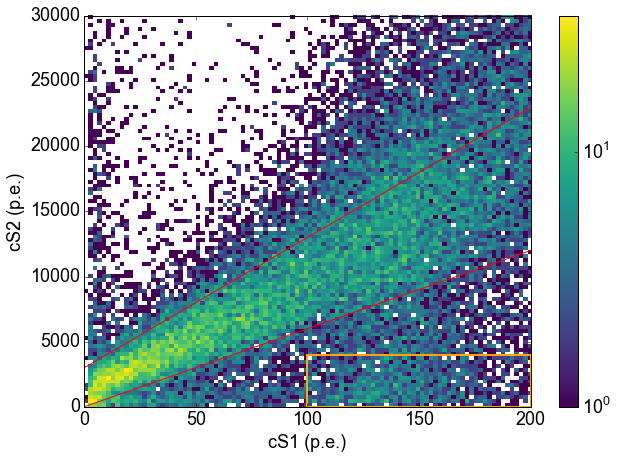

In [42]:
plt.plot(x_plot, er_high(x_plot), color='red')
plt.plot(x_plot, er_low(x_plot),  color='red')
bg.plot_cs1cs2(bins=100, range=((0, 200), (0, 30e3)), norm=LogNorm())
plt.colorbar()
draw_box((100, 200), (0, 4000), edgecolor='orange', lw=2)
plt.show()

In [43]:
len(bg.d) / (6 * 3600) #/ (0.2 * 0.085) 

1.3762962962962964

In [44]:
1 / (0.2 * 0.085) 

58.8235294117647

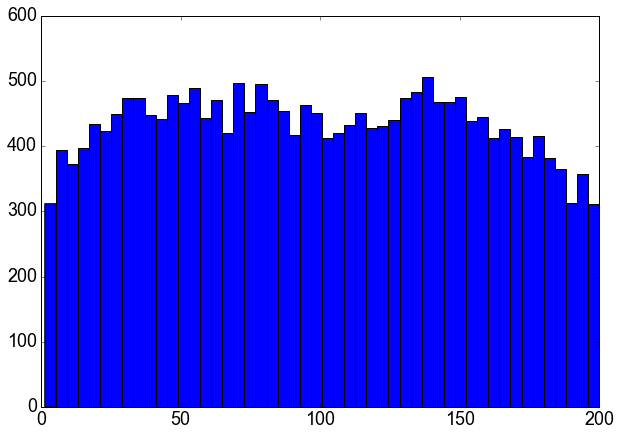

In [45]:
plt.hist(d_er['cs1'], bins=50)
plt.show()

In [46]:
good = d_er
good_low_s2 = cuts.range_selection(d_er, 'cs2', (0, 4000))
good_low_s1 = cuts.range_selection(d_er, 'cs1', (100, 200))

bad = cuts.range_selection(bg.d, 'cs1', (100, 200))
bad = cuts.range_selection(bad, 'cs2', (0, 4000))

cs2 in [0, 4000) selection: 18138 rows removed (16.25% passed)
cs1 in [100, 200) selection: 11034 rows removed (49.05% passed)
cs1 in [100, 200) selection: 12770 rows removed (57.04% passed)
cs2 in [0, 4000) selection: 14995 rows removed (11.58% passed)


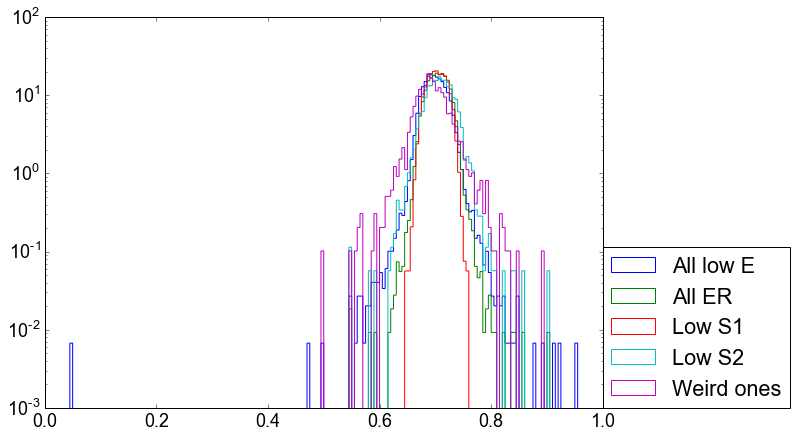

In [47]:
plt.hist(bg.d['s2_area_fraction_top'], bins=200, histtype='step', label='All low E', normed=True, range=(0,1))
plt.hist(good['s2_area_fraction_top'], bins=200, histtype='step', label='All ER', normed=True, range=(0,1))
plt.hist(good_low_s1['s2_area_fraction_top'], bins=200, histtype='step', label='Low S1', normed=True, range=(0,1))
plt.hist(good_low_s2['s2_area_fraction_top'], bins=200, histtype='step', label='Low S2', normed=True, range=(0,1))
plt.hist(bad['s2_area_fraction_top'], bins=200, histtype='step', label='Weird ones', normed=True, range=(0,1))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [48]:
plt.hist(bg.d['s1_aft_difference'], bins=200, histtype='step', label='All low E', normed=True, range=(0,1))
plt.hist(good['s1_aft_difference'], bins=200, histtype='step', label='All ER', normed=True, range=(0,1))
plt.hist(good_low_s1['s1_aft_difference'], bins=200, histtype='step', label='Low S1', normed=True, range=(0,1))
plt.hist(good_low_s2['s1_aft_difference'], bins=200, histtype='step', label='Low S2', normed=True, range=(0,1))
plt.hist(bad['s1_aft_difference'], bins=200, histtype='step', label='Weird ones', normed=True, range=(0,1))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

KeyError: 's1_aft_difference'

In [ ]:
plt.hist(bg.d['t'], bins=200, histtype='step', label='All low E', normed=True, range=(0,6*3600))
plt.hist(good['t'], bins=200, histtype='step', label='All ER', normed=True, range=(0,6*3600))
plt.hist(good_low_s1['t'], bins=200, histtype='step', label='Low S1', normed=True, range=(0,6*3600))
plt.hist(good_low_s2['t'], bins=200, histtype='step', label='Low S2', normed=True, range=(0,6*3600))
plt.hist(bad['t'], bins=200, histtype='step', label='Weird ones', normed=True, range=(0,6*3600))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
plt.hist(bg.d['z'], bins=200, histtype='step', label='All low E', normed=True, range=(-10,0))
plt.hist(good['z'], bins=200, histtype='step', label='All ER', normed=True, range=(-10,0))
plt.hist(good_low_s1['z'], bins=200, histtype='step', label='Low S1', normed=True, range=(-10,0))
plt.hist(good_low_s2['z'], bins=200, histtype='step', label='Low S2', normed=True, range=(-10,0))
plt.hist(bad['z'], bins=200, histtype='step', label='Weird ones', normed=True, range=(-10,0))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
plt.scatter(good['drift_time'], good['s2_range_50p_area'], edgecolor='None', color='red', s=5)
plt.scatter(bad['drift_time'], bad['s2_range_50p_area'], edgecolor='None')
plt.axhline(100)

In [ ]:
ran = (-500, 500)

plt.hist(bg.d['s2_width_difference'], bins=200, histtype='step', label='All low E', normed=True, range=ran)
plt.hist(good['s2_width_difference'], bins=200, histtype='step', label='All ER', normed=True, range=ran)
plt.hist(good_low_s1['s2_width_difference'], bins=200, histtype='step', label='Low S1', normed=True, range=ran)
plt.hist(good_low_s2['s2_width_difference'], bins=200, histtype='step', label='Low S2', normed=True, range=ran)
plt.hist(bad['s2_width_difference'], bins=200, histtype='step', label='Weird ones', normed=True, range=ran)
# plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
bg.cut_s1_aft(plot=True, apply=False)

In [ ]:
bla = bg.d

In [ ]:
# Error from near the edges where interpolation fails
bla = cuts.isfinite(bla, 's1_aft_difference')

In [ ]:
plt.set_cmap('jet')
plt.scatter(bla['cs1'], bla['cs2'], c=np.abs(bla['s1_aft_difference']), vmax= 0.1,
            edgecolor='None', marker='.', s=10)
plt.colorbar()
plt.xlim(0, 200)
plt.ylim(0, 30e3)

### Weird population NR

In [ ]:
ambe_1.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 200), (0, 30000)))
plt.plot(x_plot, nr_low(x_plot))
plt.plot(x_plot, nr_high(x_plot))
draw_box((100, 200), (0, 2500), edgecolor='orange')

In [ ]:
good = d_nr
good_low_s2 = cuts.range_selection(d_nr, 'cs2', (0, 2500))
good_low_s1 = cuts.range_selection(d_er, 'cs1', (100, 200))

bad = cuts.range_selection(ambe_1.d, 'cs1', (100, 200))
bad = cuts.range_selection(bad, 'cs2', (0, 2500))

In [ ]:
ran = (-500, 500)

plt.hist(bg.d['s2_width_difference'], bins=200, histtype='step', label='All low E', normed=True, range=ran)
plt.hist(good['s2_width_difference'], bins=200, histtype='step', label='All NRa', normed=True, range=ran)
plt.hist(good_low_s1['s2_width_difference'], bins=200, histtype='step', label='Low S1', normed=True, range=ran)
plt.hist(good_low_s2['s2_width_difference'], bins=200, histtype='step', label='Low S2', normed=True, range=ran)
plt.hist(bad['s2_width_difference'], bins=200, histtype='step', label='Weird ones', normed=True, range=ran)
# plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
plt.hist(bg.d['z'], bins=200, histtype='step', label='All low E', normed=True, range=(-10,0))
plt.hist(good['z'], bins=200, histtype='step', label='All ER', normed=True, range=(-10,0))
plt.hist(good_low_s1['z'], bins=200, histtype='step', label='Low S1', normed=True, range=(-10,0))
plt.hist(good_low_s2['z'], bins=200, histtype='step', label='Low S2', normed=True, range=(-10,0))
plt.hist(bad['z'], bins=200, histtype='step', label='Weird ones', normed=True, range=(-10,0))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
plt.hist(bg.d['s2_area_fraction_top'], bins=200, histtype='step', label='All low E', normed=True, range=(0,1))
plt.hist(good['s2_area_fraction_top'], bins=200, histtype='step', label='All ER', normed=True, range=(0,1))
plt.hist(good_low_s1['s2_area_fraction_top'], bins=200, histtype='step', label='Low S1', normed=True, range=(0,1))
plt.hist(good_low_s2['s2_area_fraction_top'], bins=200, histtype='step', label='Low S2', normed=True, range=(0,1))
plt.hist(bad['s2_area_fraction_top'], bins=200, histtype='step', label='Weird ones', normed=True, range=(0,1))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [49]:
# def append_waveforms(df, run_names, verbose=False):
#     '''
#     Get the S1 pulse shape only for the events in the dataframe.
#     '''
#     assert (max(df['run_number']) +1 == len(run_names))    
#     d_s1pulse_list = []
#     for rn_i, rn in tqdm(enumerate(run_names)):
#         event_numbers_this_dataset = df[df['run_number'] == rn_i]['event_number'].values
#         if verbose: print(rn)
#         d_s1pulse = hax.minitrees.load(datasets=rn, treemakers=[S1Pulse], 
#                                 cache_file = '/home/erik/win/data/xams_run8/cache/%s_S1Pulse.cache' % rn) # cache file?
#         d_s1pulse = d_s1pulse[d_s1pulse['event_number'].isin(event_numbers_this_dataset)]
#         d_s1pulse_list.append(d_s1pulse)
#     s1_pulses_df = pd.concat(d_s1pulse_list)
#     s1_pulses = s1_pulses_df.s1_pulse.values
#     df['s1_pulse'] = s1_pulses 
#     return df

### Compute average pulse

Wait... What is the CURRENT alignment, anyway?

Well, it is aligned on the center time (area-weighted time), rounded to the next sample, which is at sample 50. Correct for this...

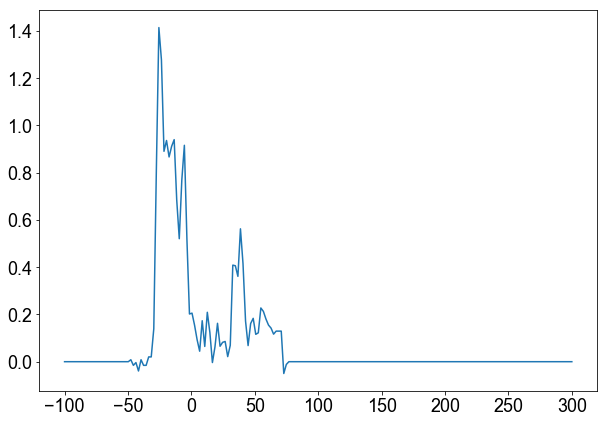

In [42]:
plt.plot(np.linspace(-100, 300, 200), d_nr['s1_pulse'].iloc[0])

### Apply the shift

s1 in [20, 30) selection: 25202 rows removed (10.90% passed)


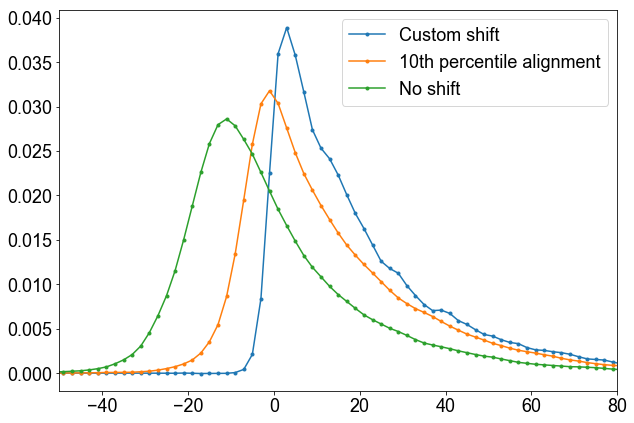

s1 in [190, 200) selection: 28182 rows removed (0.36% passed)
s1 in [190, 200) selection: 21237 rows removed (1.94% passed)
0.499755822445
0.499527714524


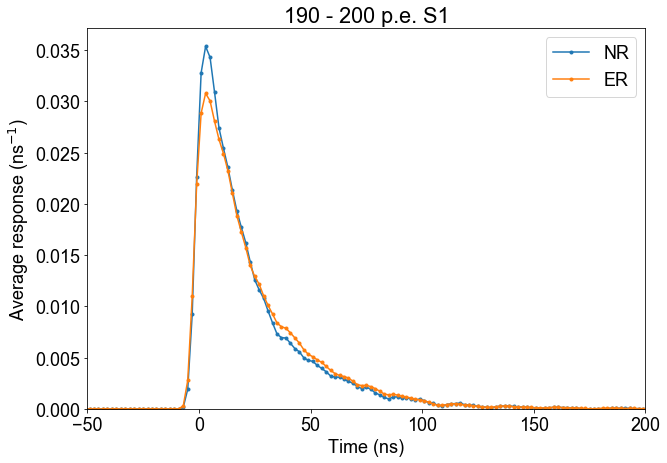

In [120]:
dt = 2
alignment_field = 's1_10p_point'

lower = 190
upper = 200


slice_nr = cuts.range_selection(d_nr, 's1', (lower, upper))
slice_er = cuts.range_selection(d_er, 's1', (lower, upper))

time, amplitude_nr = compute_average_pulse(slice_nr, alignment_field, dt=dt)
plt.plot(time, amplitude_nr, marker='.', label='NR')
print(sum(amplitude_nr))

time, amplitude_er = compute_average_pulse(slice_er, alignment_field, dt=dt)
plt.plot(time, amplitude_er, marker='.', label='ER')
print(sum(amplitude_er))
plt.xlim(-50, 200)
# plt.ylim(0)
# plt.yscale('log')
plt.ylim(1e-5)

plt.ylabel('Average response (ns$^{-1}$)')
plt.xlabel('Time (ns)')
plt.legend()
plt.title('%d - %d p.e. S1' % (lower, upper))
plt.show()


In [47]:
def compute_overlap(pulse, shift, center_time, basic_time, basic_pulse):
    time = np.linspace(-100, 300, 201)
    time = time[:200]
    shift_error = center_time - round(center_time / 2) * 2
    shifted_time = time - shift + shift_error
    pulse = np.array(pulse)/np.sum(pulse)
#    plt.plot(shifted_time, pulse)
    basic_pulse_at_shifted_time = np.interp(shifted_time, basic_time, basic_pulse)
#     plt.plot(shifted_time, basic_pulse_at_shifted_time)
    overlap = np.sum(basic_pulse_at_shifted_time * pulse)
    return overlap

In [48]:
nrness_nr = []
for i in range(len(slice_nr)):
    nrness_nr.append(compute_overlap(slice_nr['s1_pulse'].iloc[i], slice_nr['s1_time_from_midpoint_10p'].iloc[i], 
               slice_nr['s1_center_time'].iloc[i], time, amplitude_nr))
    
nrness_er = []
for i in range(len(slice_er)):
    nrness_er.append(compute_overlap(slice_er['s1_pulse'].iloc[i], slice_er['s1_time_from_midpoint_10p'].iloc[i], 
               slice_er['s1_center_time'].iloc[i], time, amplitude_nr))

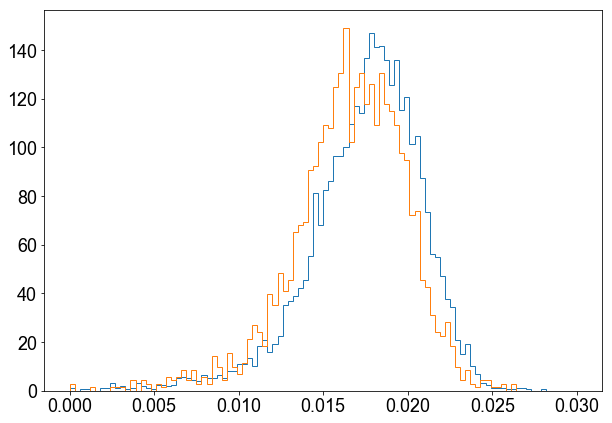

In [49]:
plt.hist(nrness_nr, bins=100, histtype='step', range=(0, 0.03), normed=True)
plt.hist(nrness_er, bins=100, histtype='step', range=(0, 0.03), normed=True)

plt.show()

In [269]:
erness_nr = []
for i in range(len(slice_nr)):
    erness_nr.append(compute_overlap(slice_nr['s1_pulse'].iloc[i], slice_nr['s1_time_from_midpoint_10p'].iloc[i], 
               slice_nr['s1_center_time'].iloc[i], time, amplitude_er))
    
erness_er = []
for i in range(len(slice_er)):
    erness_er.append(compute_overlap(slice_er['s1_pulse'].iloc[i], slice_er['s1_time_from_midpoint_10p'].iloc[i], 
               slice_er['s1_center_time'].iloc[i], time, amplitude_er))

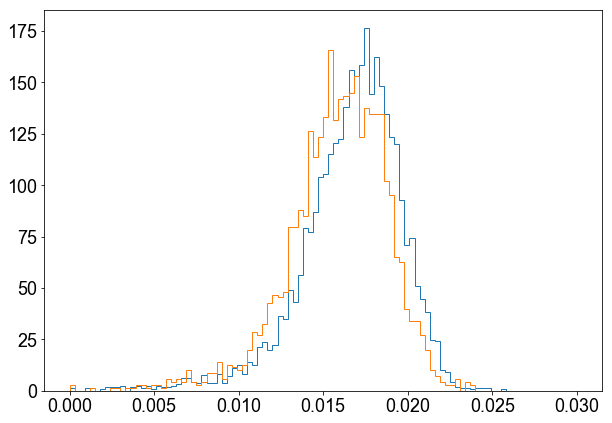

In [270]:
plt.hist(erness_nr, bins=100, histtype='step', range=(0, 0.03), normed=True)
plt.hist(erness_er, bins=100, histtype='step', range=(0, 0.03), normed=True)

plt.show()

In [229]:
slice_nr['s1_time_from_midpoint_10p'].iloc[4]

-16.929516377588342

In [273]:
slice_nr['s1_time_from_midpoint_10p'].iloc[6]

-16.859046052338286

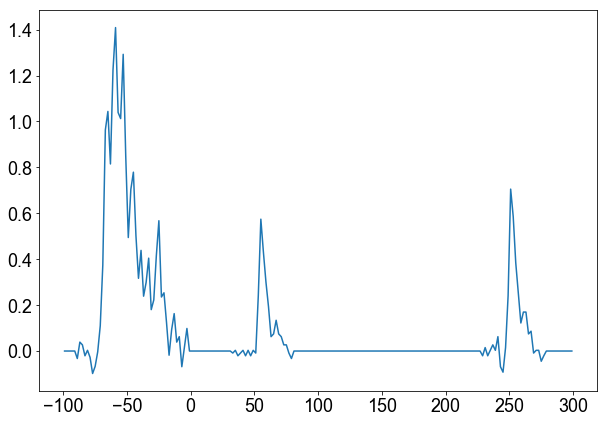

In [271]:
plt.plot(time, slice_nr['s1_pulse'].iloc[6])

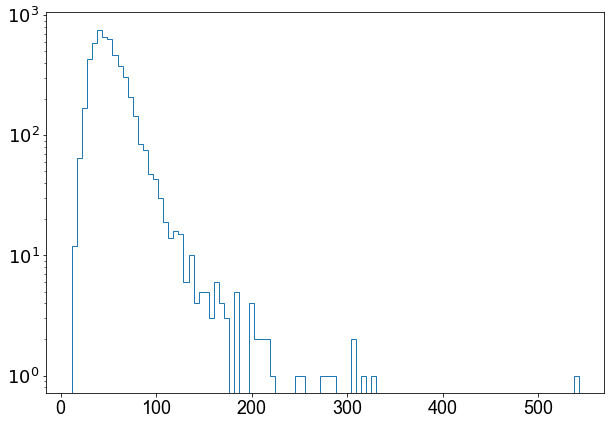

In [279]:
plt.hist(slice_nr['s1_range_80p_area'], bins=100, histtype='step')
plt.yscale('log')
plt.show()

In [280]:
slice_nr_crap = slice_nr[slice_nr['s1_range_80p_area'] > 100]

-12.0415413106


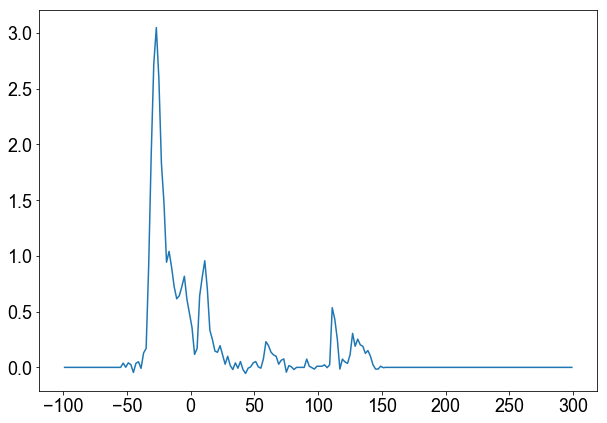

In [290]:
plt.plot(time, slice_nr_crap['s1_pulse'].iloc[6])
print(slice_nr_crap['s1_time_from_midpoint_10p'].iloc[6])

In [294]:
total_area = 0
for bla in slice_nr_crap['s1_pulse'].iloc[6]:
    total_area += bla
print(total_area)
print(slice_nr_crap['s1'].iloc[6])

fractional_area = 0
for i, bla in enumerate(slice_nr_crap['s1_pulse'].iloc[6]):
    fractional_area += bla
    if fractional_area >= 0.1 * total_area:
        print(i)
        print(fractional_area)
        print(time[i])
        break

31.687006898457184
31.6870079041
34
3.267025069333613
-31.0


In [295]:
slice_nr_crap['s1_time_from_midpoint_10p'].iloc[6]

-12.041541310649183

Here is the thing... Time from midpoint is with respect to the 50% area point, which is NOT necessarily the center time...

## Low field

In [14]:
ambe_low = XAMSAnalysis([run_names_ambe_low[0]], processed_data_path, minitree_path)

In [15]:
ambe_low.load(treemakers = ['Basics', 'Fundamentals', S1TimeProperties])

INFO:hax.__init__] Not looking for datasets in runs, db since you put use_runs_db = False


Loaded 86240 (86.2 k) events.
Total live time: 900.1 seconds (0.3 hours)


In [7]:
ambe_low.cut_interaction_exists()

Finite s1 selection: 350091 rows removed (64.63% passed)


### z correction

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


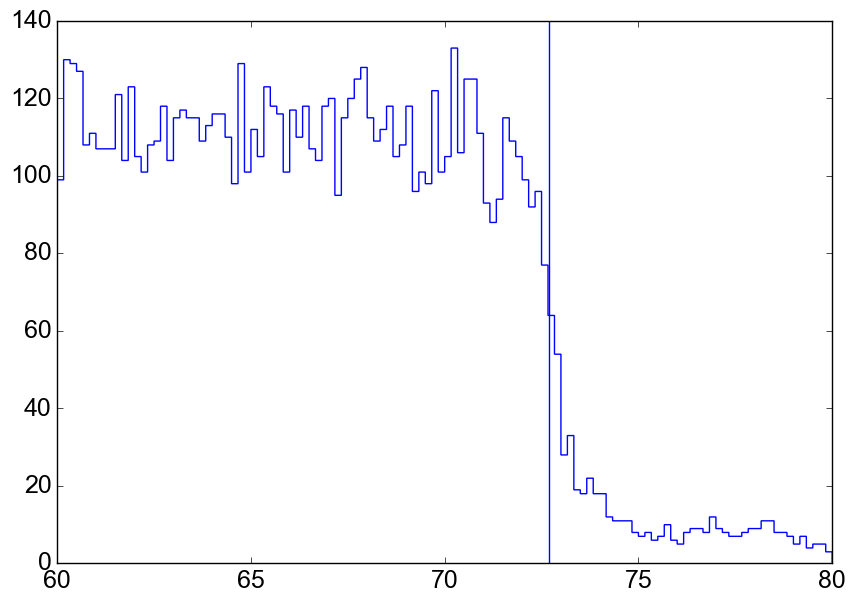

In [17]:
plt.hist(ambe_low.d['drift_time'], bins=120, histtype='step', range=(60, 80))
plt.axvline(72.7)
plt.show()

In [18]:
10 / (72.7 - 1.5)

0.14044943820224717

In [19]:
ambe_low.corr_z(1.5, 1.404)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


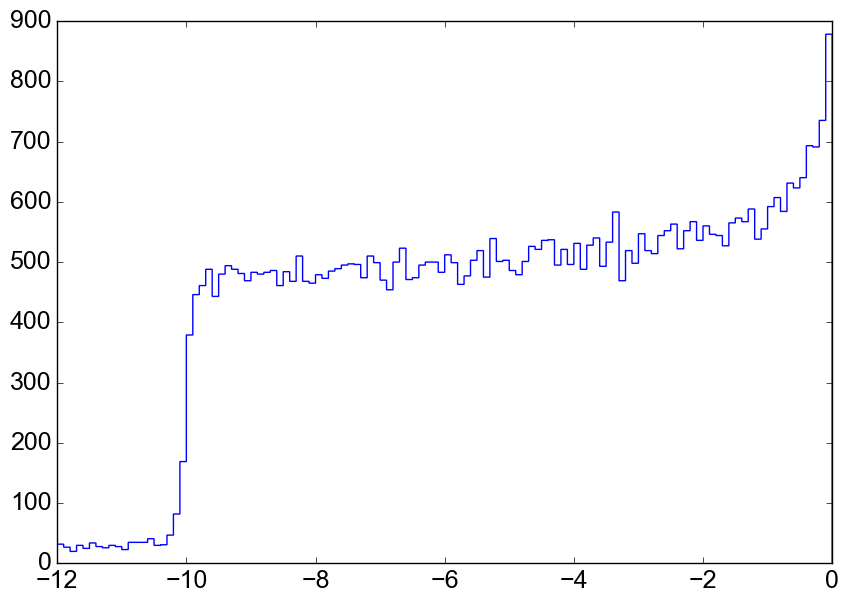

In [20]:
plt.hist(ambe_low.d['z'], bins=120, histtype='step', range=(-12, 0))
plt.show()

ms_since_previous_event above 1.0 selection: 15577 rows removed (81.94% passed)


(1000.0, 100000.0)

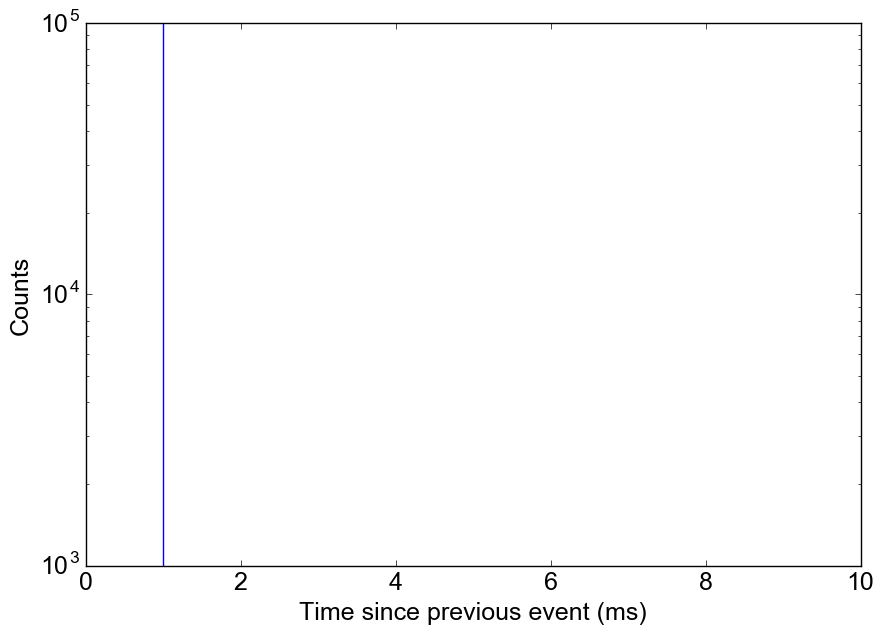

In [27]:
ambe_low.cut_time_since_previous(plot=True, apply=True, bins=100,histtype='step', range=(0, 10))
plt.yscale('log')
plt.ylim(1e3, 1e5)

In [22]:
ambe_low.cut_fiducial_volume()

z in [-9.5, -0.5) selection: 30288 rows removed (57.14% passed)


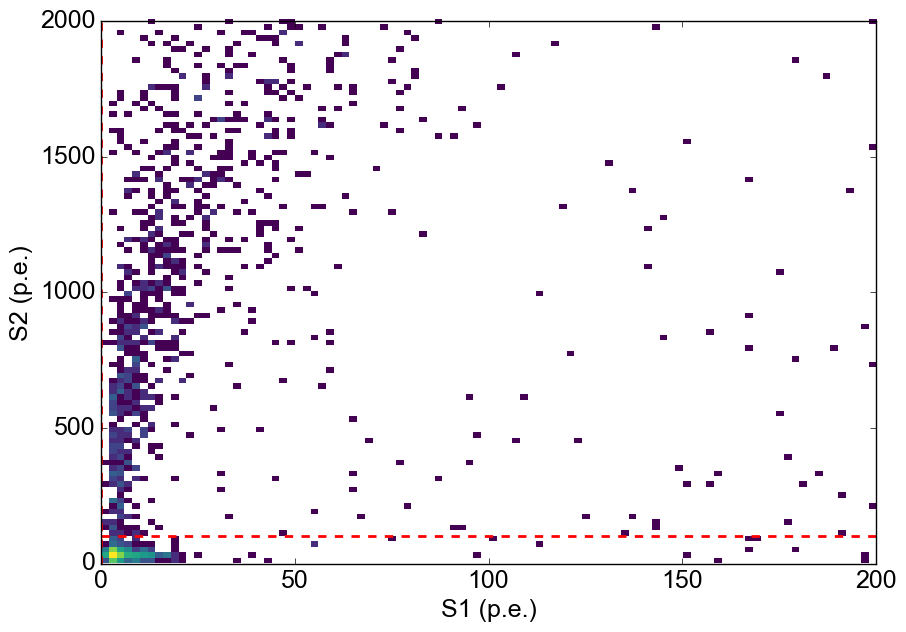

In [23]:
ambe_low.cut_thresholds(s1_threshold=0, s2_threshold=100., plot=True, apply=False, bins=100, norm=LogNorm(),
                        range=((0, 200), (0, 2e3)))

In [25]:

def read_and_cut(run_names, processed_data_path, minitree_path, treemakers = None, field='high', **kwargs):
    x = XAMSAnalysis(run_names, processed_data_path, minitree_path)
    x.load(treemakers=  treemakers, **kwargs)
    if field=='low':
        v_d = 1.404
    elif field=='high':
        v_d = 1.73
    else:
        raise ValueError('Enter a valid field type.')
    x.corr_z(1.5, v_d)
    x.corr_s1_ly_poly(ly_filename='../light_yield/data/cs137_ly_p2_sel2.pickle')
    x.corr_s2_electron_lifetime(pickle_file='../light_yield/data/cs137_electron_lifetime_sel2.pickle', verbose=True)
    x.cut_interaction_exists()
    x.cut_time_since_previous()
    x.cut_fiducial_volume()
    # x.cut_s2_range_50p_area(pickle_file='../light_yield/data/cs137_s2_width.pickle')
    x.cut_thresholds(s1_threshold=0, s2_threshold=100.)
    x.cut_largest_other_s1()
    x.cut_largest_other_s2() 

    print('Events left: %.1f k' % (len(x.d)/1000))
    return x